In [1]:
%matplotlib inline
from galaxy_analysis.plot.plot_styles import *
import matplotlib.pyplot as plt

import yt
import numpy as np
import deepdish as dd
from scipy.optimize import brentq

from galaxy_analysis.utilities import utilities

from galaxy_analysis.analysis import Galaxy
from galaxy_analysis.utilities import functions
from galaxy_analysis.particle_analysis import particle_types as ptypes

import time


WDIR = '/home/emerick/work/enzo_runs/pleiades/starIC/run11_30km/final_sndriving/'


/home/emerick/anaconda2/lib/python2.7/site-packages/astroML/time_series/periodogram.py:8: UserWarning: Using slow version of lomb_scargle. Install astroML_addons to use an optimized version
  warnings.warn("Using slow version of lomb_scargle. Install astroML_addons "
/home/emerick/code/galaxy_analysis/particle_analysis/IMF.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/emerick/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/emerick/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module

/home/emerick/code/galaxy_analysis/particle_analysis/sn_rate.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/emerick/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/emerick/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/emerick/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477

/home/emerick/code/galaxy_analysis/plot/plot_styles.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/emerick/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/emerick/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/emerick/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in star

In [2]:
reload(functions)

<module 'galaxy_analysis.utilities.functions' from '/home/emerick/code/galaxy_analysis/utilities/functions.pyc'>

In [3]:
gal = Galaxy('DD0349', wdir = WDIR)

Parsing Hierarchy : 100%|██████████| 1966/1966 [00:00<00:00, 15876.23it/s]
/home/emerick/anaconda2/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


tracer species present:  ['C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
16 mass fields defined
16 mass fraction fields defined
15 number density fields defined
129 abundance ratio fields defined
129 particle abundance ratio fields defined
5 additional helper fields defined


Parsing Hierarchy : 100%|██████████| 3845/3845 [00:00<00:00, 12622.74it/s]
/home/emerick/code/onezone/data_tables.py:89: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if  c == flag or id == flag:


In [4]:
# stars_lifetime = gal.df[('io','particle_model_lifetime')]

In [5]:
data = dd.io.load(WDIR + 'gas_abundances_5Myr.h5')

In [ ]:
nrow = 2
ncol = 3

fig, all_ax = plt.subplots(nrow,ncol)
fig.set_size_inches(8*ncol,8*nrow)

fbins   = data['DD0100']['Disk']['mass_fraction']['bins']
binsize =       (fbins[1:]) - (fbins[:-1])
centers = 0.5 * (fbins[1:] + fbins[:-1])

phase = 'Molecular'
field = 'O_Fraction'
ylim = [0.0,6]

ds_list = np.arange(80.0, 521, 5)

min_median = 1.0E80
max_median = -1.0E80

axi = 0
axj = 0
phases = ['Molecular','CNM','WNM','WIM','HIM','Disk']
phase_labels = ['Molecular','Cold Neutral','Warm Neutral','Warm Ionized','Hot Ionized','All ISM']


mean_phase = {}
std_phase  = {}
actual_mean_phase = {}
actual_std_phase  = {}
time = np.zeros(np.size(ds_list))

for k in phases:
    mean_phase[k] = np.zeros(np.size(ds_list))
    std_phase[k]  = np.zeros(np.size(ds_list))
    actual_mean_phase[k] = np.zeros(np.size(ds_list))
    actual_std_phase[k]  = np.zeros(np.size(ds_list))


xmin = 10000
xmax = -1000000
for i,j in enumerate(ds_list):
    dsname = 'DD%0004i'%(j)
    axi = 0
    axj = 0
    for ip, phase in enumerate(phases):
       # print axi, axj, phase
        ax = all_ax[(axi, axj)]
        
        y = data[dsname][phase]['mass_fraction'][field]['hist']
        mean = data[dsname][phase]['mass_fraction'][field]['mean']
        std = data[dsname][phase]['mass_fraction'][field]['std']
        median = np.log10(np.interp(0.5, np.cumsum(y)/(1.0*np.sum(y)), centers))
        label = data[dsname]['general']['Time'] - 46.0
    
    
        min_median = np.min([median, min_median])
        max_median = np.max([median, max_median])
    
        frac = 0.8
        alpha = ((i / (np.size(ds_list)*1.0))) * frac
        halpha = ((i / (np.size(ds_list)*1.0))) * frac * 0.5
        color = magma(alpha/frac) #'black' # viridis(alpha)
        lw   = 4.0
        hlw  = 4.0
        if j == np.max(ds_list):
            color = 'black'
            alpha = 1.0
            lw    = 5.0
            hlw   = 5.0
    
        norm_y = y / binsize
        plot_bins = np.log10(fbins)
        plot_histogram(ax, plot_bins, norm_y/np.max(norm_y), lw = hlw, color = color, alpha = halpha)

        selection = (y > 0) * (centers > 10**(median - 4)) * (centers < 10**(median+4))
        fit_x     = centers[selection]
        y_to_fit  = norm_y[selection]
    
        # take initial guess parameters from distribution values - compute logged dist values
        try:
            u_guess   = np.log( mean / (np.sqrt(1.0 + std*std/(mean*mean))))
            std_guess = np.sqrt(np.log(1.0 + std*std/(mean*mean)))
            xplot = np.logspace(np.log10(np.min(fit_x)), np.log10(np.max(fit_x)),4000)
            lognorm    = functions.lognormal()
            popt, pcov = lognorm.fit_function(fit_x, y_to_fit, p0 = [u_guess, std_guess])     
            xplot = np.logspace(np.log10(np.min(fit_x)), np.log10(np.max(fit_x)),4000)
            yplot = lognorm._f(xplot, *popt)
            ax.plot(np.log10(xplot), yplot/np.max(yplot), lw = lw, color = color , ls = '-', alpha = alpha) #, label = 'Fit')     
        except:
            print phase, dsname, 'failure'
            popt = [None, None]
            
        mean_phase[phase][i] = popt[0]
        actual_mean_phase[phase][i] = mean
        std_phase[phase][i]  = popt[1]
        actual_std_phase[phase][i]  = std
        time[i]              = label
        
        
        axj = axj + 1
        
        if axj >= ncol:
            axi = axi + 1
            axj = 0
        

        xmin = np.min([np.log10(xplot[0]),xmin])
        xmax = np.max([np.log10(xplot[-1]),xmax])
        
        
for i in np.arange(2):
    for j in np.arange(3):
        all_ax[(i,j)].set_xlim(xmax - 5, xmax)
        all_ax[(i,j)].semilogy()
        all_ax[(i,j)].set_ylim(1.0E-2,1.0)

        ba =  8
        ba = 0
        all_ax[(i,j)].set_xlim(-7 - ba, -2.5 - ba)   

        xy = (np.min(all_ax[(i,j)].get_xlim())+ 0.2,np.max(all_ax[(i,j)].get_ylim())*0.95)
        all_ax[(i,j)].annotate(phase_labels[(3)*(i) + j], xy = xy, xytext=xy)
        all_ax[(i,j)].set_xlabel(r'log(Oxygen Mass Fraction)')
        all_ax[(i,j)].set_ylabel(r'Peak Normalized PDF')
    #ax.set_xlim( np.log10(min_median) - 2, np.log10(max_median) + 2)

#fig.savefig(field + '_phase_evolution.png')

fig.savefig('log_panel_phase_evolution.png')

In [7]:
print data['DD0500']['CNM']['mass_fraction']['O_Fraction'].keys()
print np.sort(data.keys())

['Q1', 'std', 'Q3', 'decile_9', 'min', 'max', 'decile_1', 'hist', 'median', 'inner_quartile_range', 'd9_d1_range', 'mode', 'variance', 'mean']
['DD0050' 'DD0055' 'DD0060' 'DD0065' 'DD0070' 'DD0075' 'DD0080' 'DD0085'
 'DD0090' 'DD0095' 'DD0100' 'DD0105' 'DD0110' 'DD0115' 'DD0120' 'DD0125'
 'DD0130' 'DD0135' 'DD0140' 'DD0145' 'DD0150' 'DD0155' 'DD0160' 'DD0165'
 'DD0170' 'DD0175' 'DD0180' 'DD0185' 'DD0190' 'DD0195' 'DD0200' 'DD0205'
 'DD0210' 'DD0215' 'DD0220' 'DD0225' 'DD0230' 'DD0235' 'DD0240' 'DD0245'
 'DD0250' 'DD0255' 'DD0260' 'DD0265' 'DD0270' 'DD0275' 'DD0280' 'DD0285'
 'DD0290' 'DD0295' 'DD0300' 'DD0305' 'DD0310' 'DD0315' 'DD0320' 'DD0325'
 'DD0330' 'DD0335' 'DD0340' 'DD0345' 'DD0350' 'DD0355' 'DD0360' 'DD0365'
 'DD0370' 'DD0375' 'DD0380' 'DD0385' 'DD0390' 'DD0395' 'DD0400' 'DD0405'
 'DD0410' 'DD0415' 'DD0420' 'DD0425' 'DD0430' 'DD0435' 'DD0440' 'DD0445'
 'DD0450' 'DD0455' 'DD0460' 'DD0465' 'DD0470' 'DD0475' 'DD0480' 'DD0485'
 'DD0490' 'DD0495' 'DD0500' 'DD0505' 'DD0510' 'DD0515'

In [54]:
data[dsname][phase]['mass_fraction']['O_Fraction'].keys()


['Q1',
 'std',
 'Q3',
 'decile_9',
 'min',
 'max',
 'decile_1',
 'hist',
 'median',
 'inner_quartile_range',
 'd9_d1_range',
 'mode',
 'variance',
 'mean']

In [7]:
from scipy import integrate
from scipy.stats import distributions
from scipy import stats

def random_sample_from_cdf(npoints, xval, CDF):
    u       = np.random.rand(npoints)
    rsample = np.interp(u, CDF, xval)
    
    return rsample

def _load_data(ldata, dsname, phase, field, centers = None, IQR = False, return_dict = False):
    y      = ldata[dsname][phase]['mass_fraction'][field]['hist']
    mean   = ldata[dsname][phase]['mass_fraction'][field]['mean']
    std    = ldata[dsname][phase]['mass_fraction'][field]['std']
    q1     = ldata[dsname][phase]['mass_fraction'][field]['Q1']
    q3     = ldata[dsname][phase]['mass_fraction'][field]['Q3']
    q10    = ldata[dsname][phase]['mass_fraction'][field]['decile_1']
    q90    = ldata[dsname][phase]['mass_fraction'][field]['decile_9']

    if q3 is None or q1 is None:
        iqr           = None
        q90_q10_range = None
    else:
        iqr    = np.log10(q3) - np.log10(q1) # ldata[dsname][phase]['mass_fraction'][field]['inner_quartile_range']
        q90_q10_range = np.log10(q90) - np.log10(q10)
        
    label  = ldata[dsname]['general']['Time'] - 46.0
    
    #if (not ('median' in ldata[dsname][phase]['mass_fraction'][field].keys())):
    median = np.log10(np.interp(0.5, np.cumsum(y)/(1.0*np.sum(y)), centers))
    #else:
    #    print 'loading median from file'
    #    median = ldata[dsname][phase]['mass_fraction'][field]['median']
    
    if return_dict:
        rdict = {'y' : y, 'mean' : mean, 'median' : median, 'std' : std, 'label' : label, 'q1' : q1, 'q3' : q3,
                 'iqr' : iqr, 'q10' : q10, 'q90' : q90, 'q90_q10_range' : q90_q10_range}
        return rdict
    else:
        if IQR:
            return y, mean, median, std, label, iqr
        else:
            return y, mean, median, std, label

def _poisson_error(y):
    N = np.sum(y) * 1.0
    error = np.sqrt(y*y*(N+y)/(N**3))
    return error

def _compute_fit_and_plot(ax, bins, y, mean=None, median=None, std=None, show_hist = True, plot_PDF = True,
                          plot_CDF = False, alpha = 0.5, halpha = 0.25, color = 'black', ls = '-', Mtot = 1.0E4,
                          fit_only = False, method = 'curve_fit', x_shift = 0.0, peak_normalize = True):
    
    D_KS       = None
    D_KS_alpha = None
    CDF_diff   = None
    KS_alpha   = None
    KS_result  = None
    KS_pval    = None
    
    if plot_CDF:
        plot_PDF = False
    
    binsize =       (bins[1:]) - (bins[:-1])
    centers = 0.5 * (bins[1:] + bins[:-1])
    
    frac = 0.8
    lw   = 4.0
    hlw  = 4.0
    
    #if j == np.max(ds_list):
    #    color = 'black'
    #    alpha = 1.0
    #    lw    = 5.0
    #    hlw   = 5.0
    
    norm_y = y / binsize
    plot_bins = np.log10(bins)
    if show_hist and (not fit_only):
        if plot_PDF:
            if peak_normalize:
                _y = np.max(norm_y)
            else:
                _y = 1.0
            plot_histogram(ax, plot_bins + x_shift, norm_y / _y, lw = hlw, color = color, alpha = halpha, ls = ls)
        elif plot_CDF:
            plot_histogram(ax, plot_bins + x_shift, np.cumsum(y), lw = hlw, color = color, alpha = halpha, ls = ls)
        else:
            plot_histogram(ax, plot_bins + x_shift, y, lw = hlw, color = color, alpha = halpha, ls = ls)
    
    if ((mean is not None) and (median is not None) and (std is not None)):
            
        selection = (y > 0) * (centers > 10**(median - 4)) * (centers < 10**(median+4))
        selection = (y > np.max(y)*1.0E-3) # * (centers > 10**(median - 4)) * (centers < 10**(median + 4))
        
        if np.size(centers[selection]) < 3:
            selection = (y > 0) * (centers > 10**(median-4)) * (centers < 10**(median+4))
            
            if np.size(centers[selection]) < 3:
                print y
                
        fit_x     = centers[selection]
        y_to_fit  = norm_y[selection]
                
       # print fit_x
        
        # take initial guess parameters from distribution values - compute logged dist values
        if True:
            #error      = _poisson_error(y[selection]*Mtot) / Mtot
            #norm_error = error / binsize[selection]
            
            norm_error = np.sqrt(y[selection]*Mtot) / binsize[selection] / Mtot
            #norm_error = 0.01 * norm_y[selection]
            #if np.size(norm_error[ norm_error > y_to_fit]) > 0:
            #    norm_error[norm_error > y_to_fit] = 0.95*y_to_fit[norm_error>y_to_fit]
            if np.size(norm_error[norm_error == 0.0]) > 0:
                print 'getting zero error'
                # norm_error[norm_error == 0.0] = np.median(norm_error[norm_error>0])
            
            u_guess   = np.log( mean / (np.sqrt(1.0 + std*std/(mean*mean))))
            std_guess = np.sqrt(np.log(1.0 + std*std/(mean*mean)))
            xplot = np.logspace(np.log10(np.min(fit_x)), np.log10(np.max(fit_x)),4000)
            lognorm    = functions.lognormal()
            # print mean, std, u_guess, std_guess
            #popt, pcov = lognorm.fit_function(fit_x, y_to_fit, p0 = [u_guess, std_guess], 
            #                                           # sigma = norm_error, absolute_sigma = False, 
            #                                           bounds = ([-60,0],[0,10])) 
            popt, pcov = lognorm.fit_function(fit_x, y_to_fit, p0 = [u_guess, std_guess,], 
                                                       # sigma = norm_error, absolute_sigma = False, 
                                                       bounds = ([u_guess - 10, u_guess + 10], [-np.inf, np.inf]), 
                                                       method = method, data_cdf = np.cumsum(y[selection])) 
            xplot = np.logspace(np.log10(np.min(fit_x))-3, np.log10(np.max(fit_x))+3,4000)
            yplot = lognorm._f(xplot, *popt)
            
            #
            # Testing soem things here for goodness of fit estimation
            #
            
            # 1) chi squared - errors are hard
            chisqr          = np.sum( (lognorm._f(fit_x, *popt) - y_to_fit)**2 / (norm_error)**2)
            reduced_chisqr  = chisqr / (np.size(y_to_fit) - 2.0)
            
            # 2) Cumulative distribution and computing D between the two distributions
            mf = np.zeros(np.size(bins)-1)
            func = lambda x : lognorm._f(x, *popt)
            for i in np.arange(0, np.size(bins)-1):
                mf[i] = integrate.quad(func, bins[i], bins[i+1])[0]
            mf = np.cumsum(mf)
            CDF_diff = np.cumsum(y) - mf
            D_KS     = np.max(np.abs(CDF_diff))
            D_KS_alpha = np.sqrt(2.0/ (1.0*np.size( y[y>0]) )*(np.size(y[y>0])))                
            KS_alpha = 2.0 * np.log(- 2.0 *(D_KS / D_KS_alpha)**2)
            
      
            # try this way
            #fit_sample = random_sample_from_CDF(10000, x[y>0], lognorm._CDF(x[y>0], *popt))
            #nsample = 20
            #dat_sample = random_sample_from_cdf(nsample, centers[y>0], np.cumsum(y[y>0]))
            #func = lambda x : lognorm._CDF(x, *popt)
            #KS_result  = stats.kstest(dat_sample, func)
        
            
            # compute p-value using scipy
            N = np.size(y[y>0])
            pval_two = distributions.kstwobign.sf(D_KS*np.sqrt(N))
            if  N > 2666 or pval_two > 0.80 - N*0.3/1000.0:
                KS_pval = distributions.kstwobign.sf(D_KS*np.sqrt(N))
            else:
                KS_pval = distributions.ksone.sf(D_KS,N)*2
            
            if not fit_only:
                if plot_PDF:
                    if peak_normalize:
                        _y = np.max(yplot)
                    else:
                        _y = 1.0
                    ax.plot(np.log10(xplot) + x_shift, yplot/_y, lw = lw, color = color , ls = ls, alpha = alpha) #, label = 'Fit')     
                elif plot_CDF:
                    cplot = (bins[1:] + bins[:-1])*0.5  
                    ax.plot(np.log10(cplot) + x_shift, mf, lw = lw, color = color, ls = ls, alpha = alpha)
                    ax.plot([np.log10(cplot)[-1] + x_shift, 0 + x_shift], [mf[-1]]*2, lw = lw, color = color, ls = ls, alpha = alpha)

                                  
                
            else:
                mf = np.zeros(np.size(bins)-1)
                func = lambda x : lognorm._f(x, *popt)
                for i in np.arange(0, np.size(bins)-1):
                    mf[i] = integrate.quad(func, bins[i], bins[i+1])[0]
                    
                if not fit_only:
                    cplot = (bins[1:] + bins[:-1])*0.5    
                    ax.plot(np.log10(cplot) + x_shift, mf, lw = lw, color = color, ls = ls, alpha = alpha)
                
                
        else:
            print phase, dsname, 'failure'
            popt = [None, None]
        # print np.trapz(yplot,xplot)
  
        pdf_mean   = np.trapz(centers * norm_y, x = centers)
    
        pdf_mf = np.zeros(np.size(bins)-2)
        func = lambda x : np.interp(x, centers, norm_y)
        for i in np.arange(0, np.size(bins)-2):
            pdf_mf[i] = integrate.quad(func, bins[i+1], bins[i+2])[0]  
        pdf_mf = np.cumsum(pdf_mf)
        
        pdf_median = np.interp(0.5, pdf_mf, centers[1:])
        pdf_mode   = np.argmax( norm_y )
        pdf_std    = np.sqrt( np.trapz(centers*centers*norm_y, x = centers) - pdf_mean**2)
        
        # return x values of fit, mean of fit, and std of fit
        mean_fit = popt[0]
        std_fit  = popt[1]
        output_dict = {'mean' : mean_fit, 'std' : std_fit, 'chisqr' : chisqr, 'norm_error' : norm_error,
                       'rchisqr' : reduced_chisqr, 'npoints' : np.size(y_to_fit), 'N' : np.size(y_to_fit),
                       'fit_x' : fit_x, 'rel_error' : np.abs(norm_error/norm_y[selection]),
                       'CDF_diff' : CDF_diff, 'D_KS' : D_KS, 'D_KS_alpha' : D_KS_alpha, 'KS_alpha' : KS_alpha,
                       'num_pdf_mean' : pdf_mean, 'num_pdf_median' : pdf_median, 'num_pdf_mode' : pdf_mode,
                       'num_pdf_std'  : pdf_std, 'KS_pval' : KS_pval, 'KS_result' : KS_result}
        
        return xplot, mean_fit, std_fit, output_dict
    else:
        if ((mean is not None) or (median is not None) or (std is not None)):
            print "Must provide mean, median, and std to enable a lognormal fit"
            raise ValueError

    # return nothing if just plotting the line and doing no fitting
    return
            
#        mean_phase[phase][i] = popt[0]
#        actual_mean_phase[phase][i] = mean
#        std_phase[phase][i]  = popt[1]
#        actual_std_phase[phase][i]  = std
#        time[i]              = label
            

    


In [9]:
fbins   = data['DD0100']['Disk']['mass_fraction']['bins']
binsize =       (fbins[1:]) - (fbins[:-1])
centers = 0.5 * (fbins[1:] + fbins[:-1])

phases = ['Molecular','CNM','WNM','WIM','HIM','Disk']
ds_list = np.arange(70, 550, 5) # [ 100, 150, 200, 250, 300, 350]
ele = ['O','Fe','N','Ba']

count = 0
output_stats = {}
for dsi in ds_list:
    dsname = 'DD%0004i'%(dsi)
    output_stats[dsi] = {}
    
    for phase in phases:
        output_stats[dsi][phase] = {}
        for e in ele:
            
            field = e + '_Fraction'
            
            rdict = _load_data(data, dsname, phase, field, centers = centers, return_dict = True)
            y = rdict['y']
            mean = rdict['mean']
            median = rdict['median']
            std = rdict['std']
            iqr = rdict['iqr']
            
            Mtot = data[dsname][phase]['general']['total_mass']
     
            if (mean is None) or (np.size(y[y > 0]) == 0): # phase not present
                for k in output:
                    output[k] = None
                    
                output_stats[dsi][phase][e] = output
                continue
    
            xplot, mean_fit, std_fit, output = _compute_fit_and_plot(None, fbins, y, mean = mean, median = median, std = std,
                                                                     Mtot=Mtot, method = 'KS',
                                                                     fit_only = True)
            output['actual_mean'] = mean
            output['actual_std']  = std
            output['actual_median'] = median
            output['actual_IQR'] = iqr
            output['actual_q90q10'] = rdict['q90_q10_range']
            output_stats[dsi][phase][e] = output
    
    count += 1
    if count >= 9:
        print dsi
        count = 0

# convert to an array we can plot as a function of time
output_stats_data = {}
for phase in phases:
    output_stats_data[phase] = {}
    for e in ele:
        output_stats_data[phase][e] = {}        
        for k in output_stats[ds_list[0]][phase][e].keys():
            output_stats_data[phase][e][k] = np.array( [output_stats[x][phase][e][k] for x in ds_list])

/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in log


110
155
200
245
290
335
380
425
470


/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide


515


[ 14.7521626    5.47257829   1.51321752   0.79914233   0.67723605
   0.58290964   0.51551954   0.46077936   0.42719031   0.40601055
   0.38633089   0.3708936    0.36504303   0.33775051   0.33026466
   0.32675552   0.3338495    0.33982159   0.34559549   0.33831949
   0.31457369   0.3049547    0.31026706   0.31036992   0.30617702
   0.30175252   0.29280492   0.29180474   0.28893035   0.29588204
   0.29600577   0.29102119   0.28173977   0.27546793   0.27224831
   0.27038252   0.26988149   0.27503693   0.26762068   0.26366651
   0.26841905   0.26714004   0.25219774   0.2552964    0.26702826
   0.27516238   0.2817615    0.26349024   0.25662093   0.25138715
   0.24802669   0.2587796    0.27284498   0.27770608   0.27383587
   0.25991241   0.26219134   0.27062181   0.28699435   0.2922335
   0.28658025   0.2844864    0.28075865   0.28302495   0.27998129
   0.26271675   0.25262004   0.25282633   0.24045068   0.2448797
   0.2547793    0.25802485   0.26186019   0.27170164   0.27675428
   0.2780119

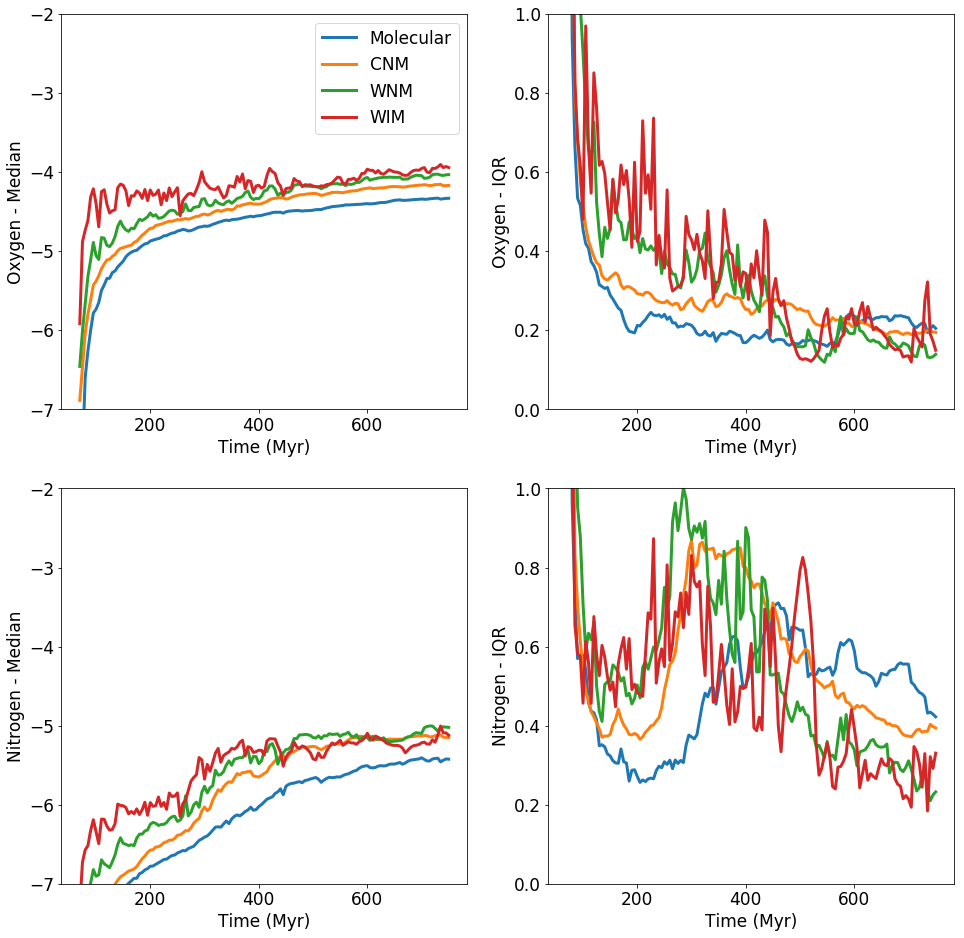

In [10]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(16,16)

for i, phase in enumerate(['Molecular','CNM','WNM','WIM']): #,'HIM']):
    if phase == 'Disk':
        continue
        
    mean  = output_stats_data[phase]['O']['actual_median']
    std  = output_stats_data[phase]['O']['actual_IQR']
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
        
    ax[(0,0)].plot(ds_list, mean, lw = 3, ls = '-', label = phase)
    ax[(0,1)].plot(ds_list, std ,  lw = 3, ls = '-', label = phase)
    ax[(0,0)].set_ylabel(r'Oxygen - Median')
    ax[(0,1)].set_ylabel(r'Oxygen - IQR')
    
    mean  = output_stats_data[phase]['N']['actual_median']
    std  = output_stats_data[phase]['N']['actual_IQR']
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
    
    ax[(1,0)].plot(ds_list, mean, lw = 3, ls = '-', label = phase)
    ax[(1,1)].plot(ds_list, std ,  lw = 3, ls = '-', label = phase)
    ax[(1,0)].set_ylabel(r'Nitrogen - Median')
    ax[(1,1)].set_ylabel(r'Nitrogen - IQR')
    #ax[(0,1)].set_ylim(0,2)
    #ax[(1,1)].set_ylim(0,2)
    
for a in [(0,0),(0,1),(1,0),(1,1)]:
#    ax[a].set_xlim(0.0, np.max(time))
    ax[a].set_xlabel('Time (Myr)')
#ax[1].semilogy()
#ax[0].set_ylim(-8, -2)
#ax[1].set_ylim(1.0E-1, 100.0)

ax[(0,0)].set_ylim(-7, -2)
ax[(1,0)].set_ylim(-7, -2)

ax[(0,1)].set_ylim(0.0, 1.0)
ax[(1,1)].set_ylim(0.0, 1.0)


    
ax[(0,0)].legend(loc='best')


print output_stats_data['CNM']['O']['actual_IQR']

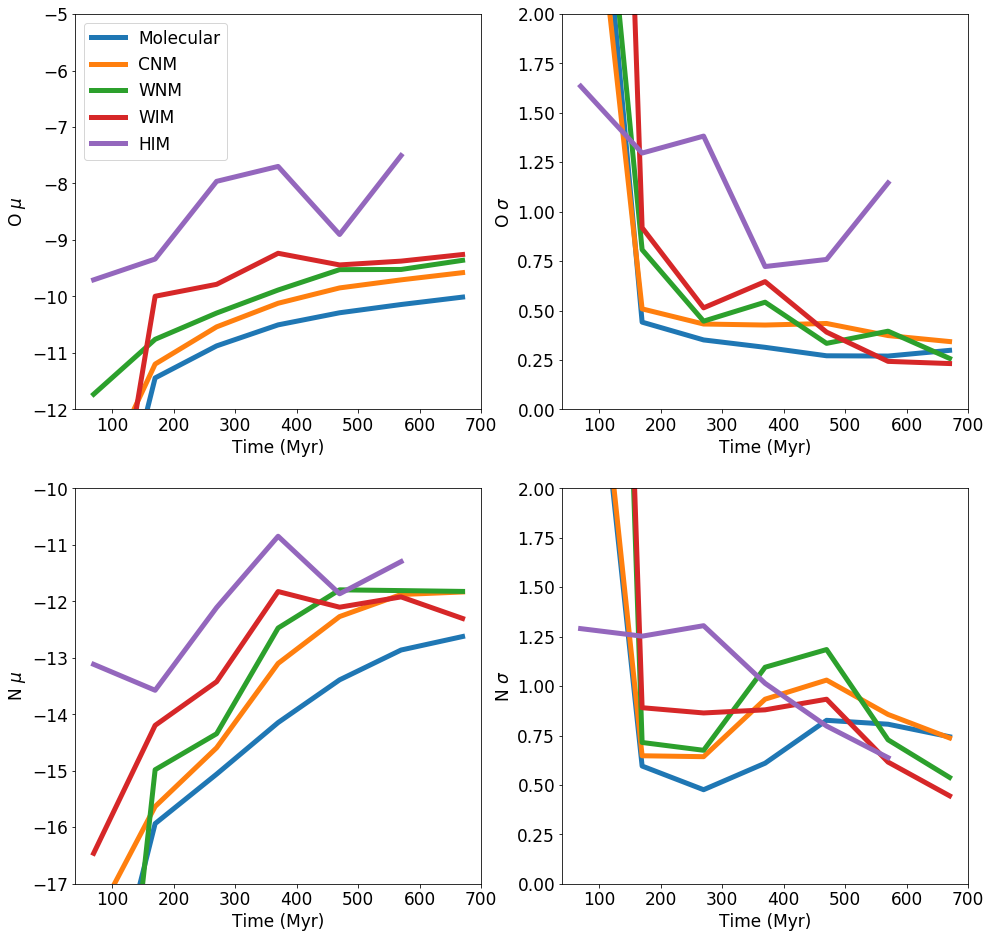

In [16]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(16,16)

for i, phase in enumerate(['Molecular','CNM','WNM','WIM','HIM']):
    if phase == 'Disk':
        continue
        
    mean  = output_stats_data[phase]['O']['mean']
    std  = output_stats_data[phase]['O']['std']
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
        
    ax[(0,0)].plot(ds_list, mean, lw = 5, ls = '-', label = phase)
    ax[(0,1)].plot(ds_list, std ,  lw = 5, ls = '-', label = phase)
    ax[(0,0)].set_ylabel(r'O $\mu$')
    ax[(0,1)].set_ylabel(r'O $\sigma$')
    
    mean  = output_stats_data[phase]['N']['mean']
    std  = output_stats_data[phase]['N']['std']
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
    
    ax[(1,0)].plot(ds_list, mean, lw = 5, ls = '-', label = phase)
    ax[(1,1)].plot(ds_list, std ,  lw = 5, ls = '-', label = phase)
    ax[(1,0)].set_ylabel(r'N $\mu$')
    ax[(1,1)].set_ylabel(r'N $\sigma$')
    ax[(0,1)].set_ylim(0,2)
    ax[(1,1)].set_ylim(0,2)
    
for a in [(0,0),(0,1),(1,0),(1,1)]:
#    ax[a].set_xlim(0.0, np.max(time))
    ax[a].set_xlabel('Time (Myr)')
#ax[1].semilogy()
#ax[0].set_ylim(-8, -2)
#ax[1].set_ylim(1.0E-1, 100.0)

ax[(0,0)].set_ylim(-12,-5)
ax[(1,0)].set_ylim(-17,-10)


    
ax[(0,0)].legend(loc='best')


TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'

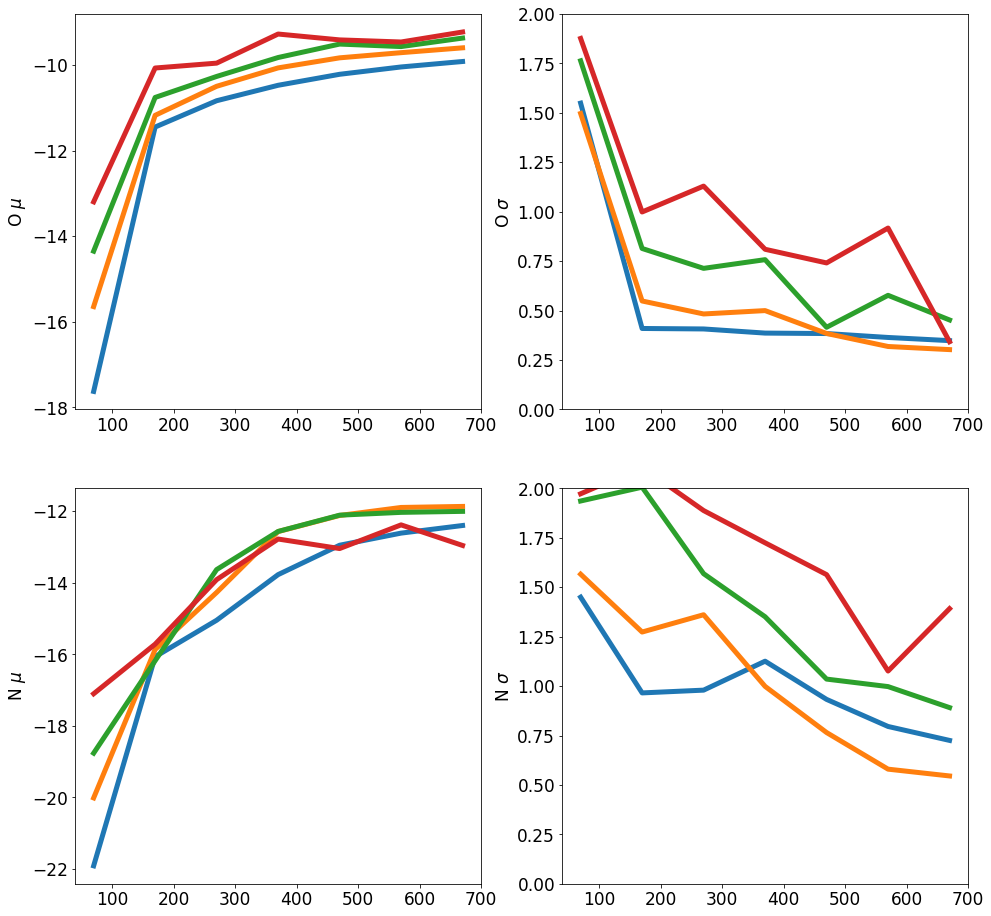

In [18]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(16,16)

for i, phase in enumerate(['Molecular','CNM','WNM','WIM','HIM']):
    if phase == 'Disk':
        continue
        
    mean  = output_stats_data[phase]['O']['num_pdf_mean']
    std   = output_stats_data[phase]['O']['num_pdf_std']
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
    
    ln_mean = np.log(  mean / np.sqrt(1.0 + std**2/mean**2))
    ln_std  = np.sqrt(  np.log(1.0 + std**2/mean**2))
        
    ax[(0,0)].plot(ds_list, ln_mean, lw = 5, ls = '-', label = phase)
    ax[(0,1)].plot(ds_list, ln_std ,  lw = 5, ls = '-', label = phase)
    ax[(0,0)].set_ylabel(r'O $\mu$')
    ax[(0,1)].set_ylabel(r'O $\sigma$')
    
    mean  = output_stats_data[phase]['N']['num_pdf_mean']
    std  = output_stats_data[phase]['N']['num_pdf_std']
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
    
    ln_mean = np.log(  mean / np.sqrt(1.0 + std**2/mean**2))
    ln_std  = np.sqrt(  np.log(1.0 + std**2/mean**2))
    
    ax[(1,0)].plot(ds_list, ln_mean, lw = 5, ls = '-', label = phase)
    ax[(1,1)].plot(ds_list, ln_std ,  lw = 5, ls = '-', label = phase)
    ax[(1,0)].set_ylabel(r'N $\mu$')
    ax[(1,1)].set_ylabel(r'N $\sigma$')
    ax[(0,1)].set_ylim(0,2)
    ax[(1,1)].set_ylim(0,2)
    
for a in [(0,0),(0,1),(1,0),(1,1)]:
#    ax[a].set_xlim(0.0, np.max(time))
    ax[a].set_xlabel('Time (Myr)')
#ax[1].semilogy()
#ax[0].set_ylim(-8, -2)
#ax[1].set_ylim(1.0E-1, 100.0)

ax[(0,0)].set_ylim(-12,-5)
ax[(1,0)].set_ylim(-17,-10)


    
ax[(0,0)].legend(loc='best')


TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'

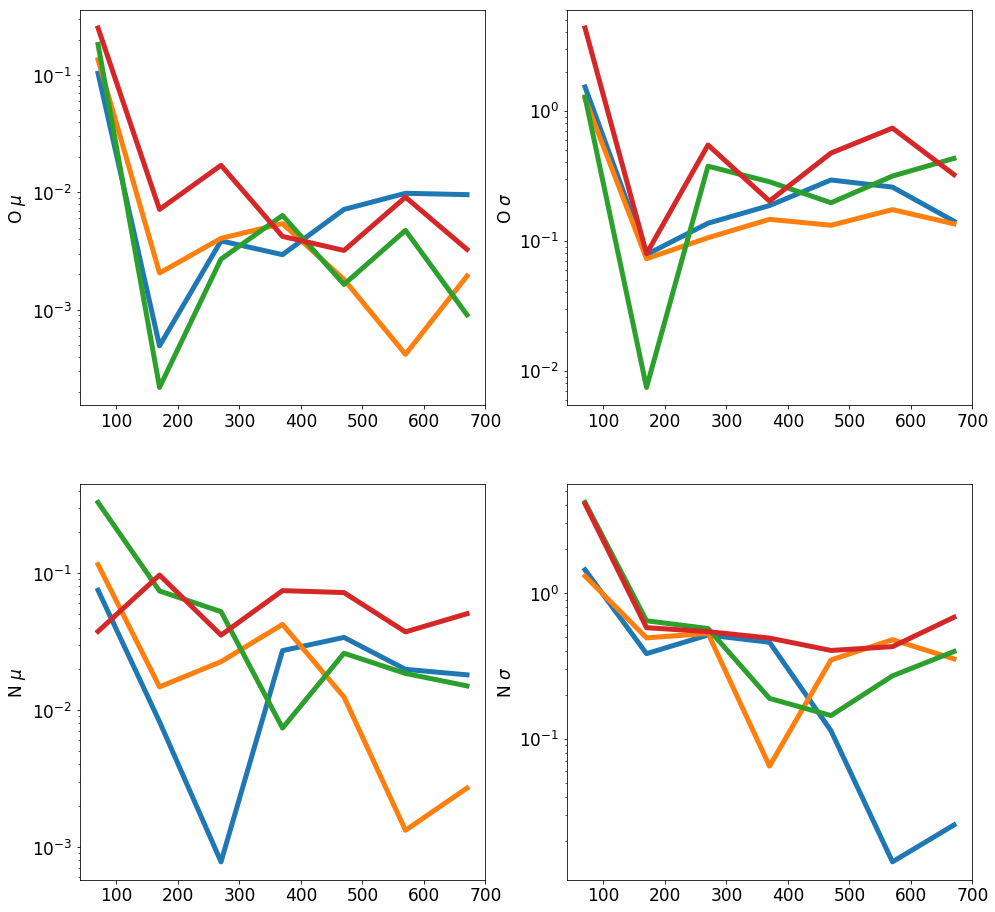

In [23]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(16,16)

for i, phase in enumerate(['Molecular','CNM','WNM','WIM','HIM']):
    if phase == 'Disk':
        continue
        
    pdf_mean  = output_stats_data[phase]['O']['num_pdf_mean']
    mean      = output_stats_data[phase]['O']['mean']
    pdf_std   = output_stats_data[phase]['O']['num_pdf_std']
    std       = output_stats_data[phase]['O']['std']
    ln_pdf_mean = np.log(  pdf_mean / np.sqrt(1.0 + pdf_std**2/pdf_mean**2))
    ln_pdf_std  = np.sqrt(  np.log(1.0 + pdf_std**2/pdf_mean**2))
    
    mean_err  = np.abs((mean - ln_pdf_mean)/ln_pdf_mean)
    std_err  = np.abs((std - ln_pdf_std)/ln_pdf_std)
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
        
    ax[(0,0)].plot(ds_list, mean_err, lw = 5, ls = '-', label = phase)
    ax[(0,1)].plot(ds_list, std_err ,  lw = 5, ls = '-', label = phase)
    ax[(0,0)].set_ylabel(r'O $\mu$')
    ax[(0,1)].set_ylabel(r'O $\sigma$')
    
    pdf_mean  = output_stats_data[phase]['N']['num_pdf_mean']
    mean      = output_stats_data[phase]['N']['mean']
    pdf_std   = output_stats_data[phase]['N']['num_pdf_std']
    std       = output_stats_data[phase]['N']['std']
    ln_pdf_mean = np.log(  pdf_mean / np.sqrt(1.0 + pdf_std**2/pdf_mean**2))
    ln_pdf_std  = np.sqrt(  np.log(1.0 + pdf_std**2/pdf_mean**2))
    
    mean_err  = np.abs((mean - ln_pdf_mean)/ln_pdf_mean)
    std_err  = np.abs((std - ln_pdf_std)/ln_pdf_std)
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
    
    ax[(1,0)].plot(ds_list, mean_err, lw = 5, ls = '-', label = phase)
    ax[(1,1)].plot(ds_list, std_err ,  lw = 5, ls = '-', label = phase)
    ax[(1,0)].set_ylabel(r'N $\mu$')
    ax[(1,1)].set_ylabel(r'N $\sigma$')
    ax[(0,0)].semilogy()
    ax[(0,1)].semilogy()
    ax[(1,0)].semilogy()
    ax[(1,1)].semilogy()
    #ax[(0,1)].set_ylim(0,2)
    #ax[(1,1)].set_ylim(0,2)
    
for a in [(0,0),(0,1),(1,0),(1,1)]:
#    ax[a].set_xlim(0.0, np.max(time))
    ax[a].set_xlabel('Time (Myr)')
    
#ax[1].semilogy()
#ax[0].set_ylim(-8, -2)
#ax[1].set_ylim(1.0E-1, 100.0)

#ax[(0,0)].set_ylim(-12,-5)
#ax[(1,0)].set_ylim(-17,-10)


    
ax[(0,0)].legend(loc='best')


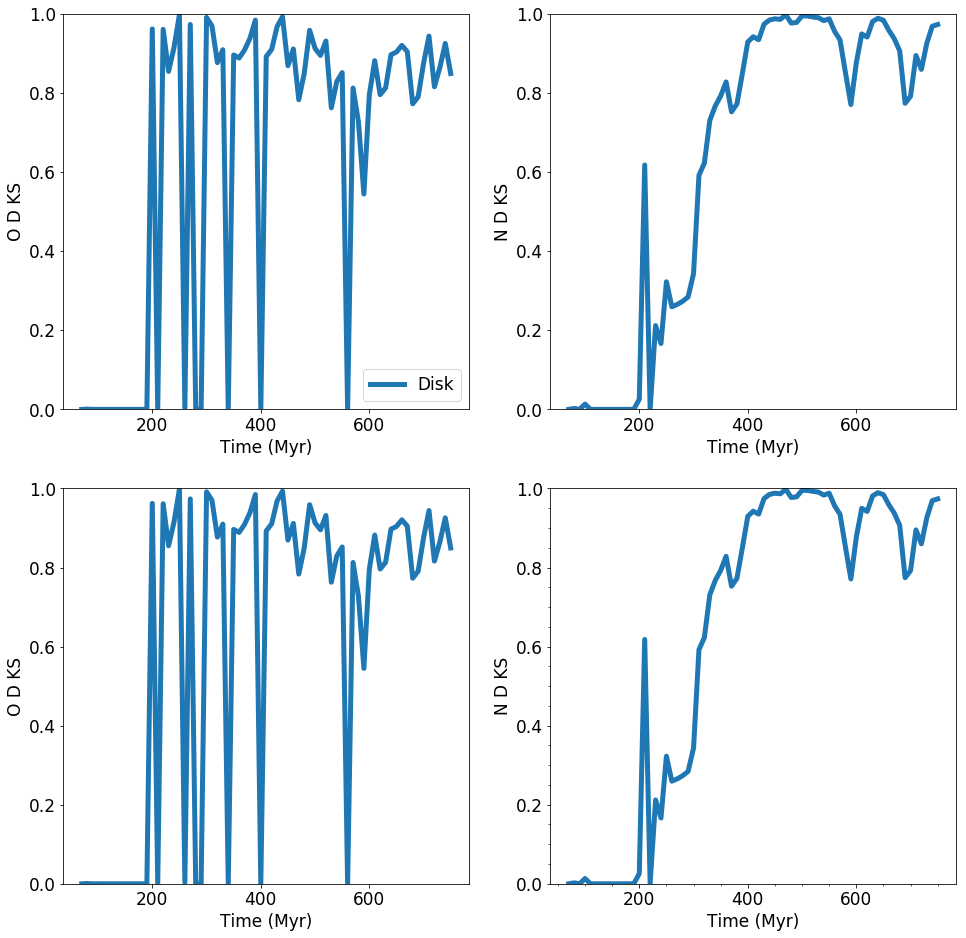

In [24]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(16,16)

for i, phase in enumerate(['Disk']):# enumerate(['Molecular','CNM','WNM','WIM']):#'WNM','WIM','HIM']):
    #if phase == 'Disk':
        continue
        
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    y = output_stats_data[phase]['O']['KS_pval']
    ax[(0,0)].plot(ds_list, y, lw = 5, ls = '-', label = phase)
    #print phase, 'O', output_stats_data[phase]['O']['KS_alpha']
    ax[(1,0)].plot(ds_list, y ,  lw = 5, ls = '-', label = phase)
    ax[(0,0)].set_ylabel(r'O D KS')
    ax[(1,0)].set_ylabel(r'O D KS')
    
    #mean  = output_stats_data[phase]['N']['mean']
    #std  = output_stats_data[phase]['N']['std']
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
    
    y = output_stats_data[phase]['N']['KS_pval']
    ax[(0,1)].plot(ds_list, y, lw = 5, ls = '-', label = phase)
    #print phase, 'O', output_stats_data[phase]['N']['KS_alpha']
    ax[(1,1)].plot(ds_list, y ,  lw = 5, ls = '-', label = phase)
    ax[(0,1)].set_ylabel(r'N D KS')
    ax[(1,1)].set_ylabel(r'N D KS')
    #ax[(1,0)].set_ylim(0,2)
    #ax[(1,1)].set_ylim(0,2)
    
for a in [(0,0),(0,1),(1,0),(1,1)]:
    ax[a].set_ylim(0.0,1.0)
    ax[a].set_xlabel('Time (Myr)')
plt.minorticks_on()
#ax[1].semilogy()
#ax[0].set_ylim(-8, -2)
#ax[1].set_ylim(1.0E-1, 100.0)

    
ax[(0,0)].legend(loc='best')


In [20]:
np.log10(10.0)

1.0

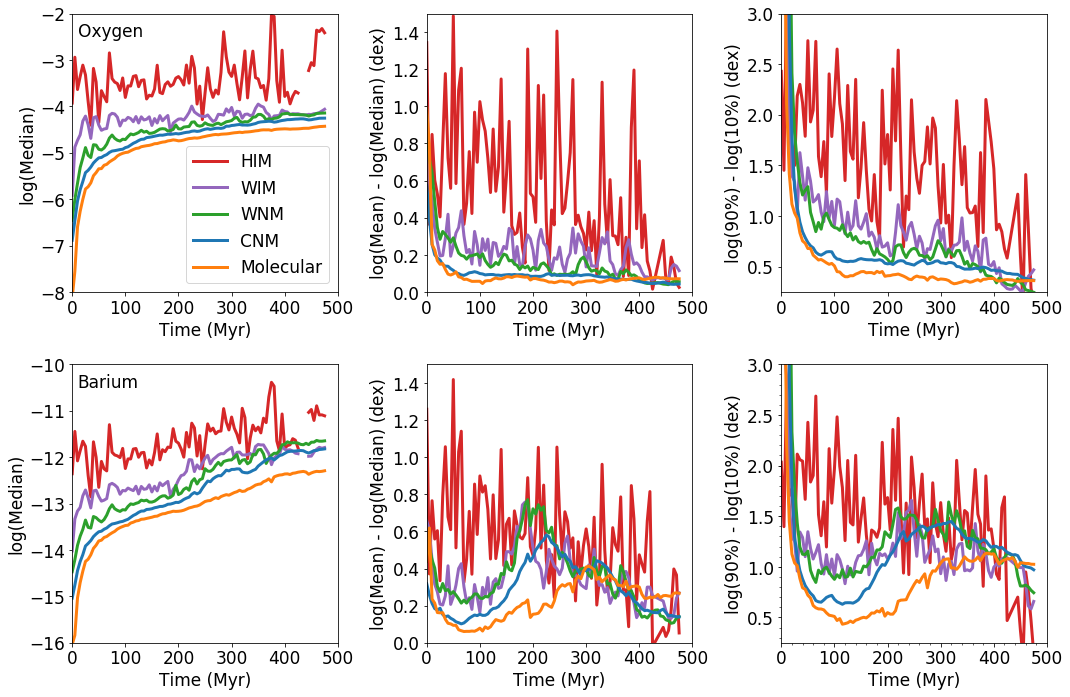

In [36]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,10)

pc = {'Molecular' : 'C1', 'CNM' : 'C0', 'WNM' : 'C2', 'WIM':'C4','HIM' : 'C3'}

x = ds_list - ds_list[0]

for i, phase in enumerate(['HIM','WIM','WNM','CNM','Molecular']):
    if phase == 'Disk':
        continue
        
    mean  = output_stats_data[phase]['O']['actual_mean']
    iqr  = output_stats_data[phase]['O']['actual_IQR']
    median = output_stats_data[phase]['O']['actual_median']
    std = output_stats_data[phase]['O']['actual_std']
    q90q10 = output_stats_data[phase]['O']['actual_q90q10']
    select = std != np.array(None)
    ds_list = np.array(ds_list)
    
        # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
    #mean = np.log10(mean)
    #median = np.log10(median)
    #std = np.log10(std)
    log_mean = np.log10((mean[select]).astype(np.float64))
    ax[(0,0)].plot(x, median, lw = 3, ls = '-', label = phase, color = pc[phase])
    ax[(0,1)].plot(x[select], log_mean - median[select],  lw = 3, ls = '-', label = phase, color = pc[phase])
    ax[(0,2)].plot(x[select], q90q10[select], lw = 3, ls = '-', label = phase, color = pc[phase])
    ax[(0,0)].set_ylabel(r'log(Median)')
    ax[(0,1)].set_ylabel(r'log(Mean) - log(Median) (dex)')
    ax[(0,2)].set_ylabel(r'log(90%) - log(10%) (dex)')
    
    ele2 = 'Ba'
    
    mean  = output_stats_data[phase][ele2]['actual_mean']
    iqr  = output_stats_data[phase][ele2]['actual_IQR']
    median  = output_stats_data[phase][ele2]['actual_median']
    std = output_stats_data[phase][ele2]['actual_std']
    q90q10 = output_stats_data[phase][ele2]['actual_q90q10']

    select = std != np.array(None)


    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
    
    #mean = np.log10(mean)
    #median = np.log10(median)
    #std = np.log10(std)
    log_mean = np.log10((mean[select]).astype(np.float64))
    ax[(1,0)].plot(x, median, lw = 3, ls = '-', label = phase,color = pc[phase])
    ax[(1,1)].plot(x[select], log_mean - median[select] ,  lw = 3, ls = '-', label = phase,color = pc[phase])
    ax[(1,2)].plot(x[select], q90q10[select], lw = 3, ls = '-', label = phase,color = pc[phase])

    ax[(1,0)].set_ylabel(r'log(Median)')
    ax[(1,1)].set_ylabel(r'log(Mean) - log(Median) (dex)')
    ax[(1,2)].set_ylabel(r'log(90%) - log(10%) (dex)')
    
    plt.minorticks_on()
    #ax[(0,2)].set_ylim(0,2)
    #ax[(1,2)].set_ylim(0,2)
    
for a in [(0,0),(0,1),(1,0),(1,1), (0,2),(1,2)]:
    ax[a].set_xlim(0.0, 500.0)
    ax[a].set_xlabel(r'Time (Myr)')
    
#for a in [(0,0),(1,0)]:
#    ax[a].semilogy()
    
ax[(0,0)].set_ylim(-8, -2)
ax[(0,1)].set_ylim(0, 1.5)
ax[(0,2)].set_ylim(0.25, 3.0)

xy = (10, -2.5)
ax[(0,0)].annotate('Oxygen',xy,xy)


xy = (10, -10.5)
ax[(1,0)].annotate('Barium',xy,xy)
#ax[(0,2)].set_ylim(1.0E-7, 10**(-1.5))
#ax[1].semilogy()
#ax[0].set_ylim(-8, -2)
#ax[1].set_ylim(1.0E-1, 100.0)


ax[(1,0)].set_ylim( ax[(0,0)].get_ylim())
ax[(1,0)].set_ylim( -16, -10)

ax[(1,1)].set_ylim( ax[(0,1)].get_ylim())
#ax[(1,2)].set_ylim(1.0E-8, 10**(-2.5))
#ax[(0,0)].set_ylim(-12,-5)
ax[(1,2)].set_ylim( ax[(0,2)].get_ylim())


    
ax[(0,0)].legend(loc='best')
plt.tight_layout()

fig.savefig('oxygen_barium_phases_CDF_evolution.png')

In [24]:

# convert to an array we can plot as a function of time
output_stats_data = {}
for phase in phases:
    output_stats_data[phase] = {}
    for e in ele:
        output_stats_data[phase][e] = {}        
        for k in output_stats[ds_list[0]][phase][e].keys():
            output_stats_data[phase][e][k] = np.array( [output_stats[x][phase][e][k] for x in ds_list])

KeyError: 'O'

In [19]:
output_stats_data['CNM']['O']['mean']

array([-13.92550261,  -6.9415932 , -11.66855442])

/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


80 O -9.512303 2.830116 0.168037
80 Fe -13.368412 1.915730 0.317359
80 N -13.269002 1.686768 0.183986
80 Ba -29.310803 1.681067 0.323073
90 O -6.381082 2.307049 0.233678
90 Fe -9.981738 2.763542 0.140886
90 N -11.783274 1.733626 0.081976
90 Ba -26.233532 2.057379 0.147836
100 O -9.228178 1.843883 0.087490
100 Fe -10.860137 1.908316 0.177293
100 N -13.581245 1.626131 0.039831
100 Ba -28.659631 1.740323 0.058099
110 O -7.449120 1.711730 0.046918
110 Fe -11.999142 1.200579 0.232842
110 N -12.272792 1.384291 0.132778
110 Ba -27.302974 1.383174 0.153592
120 O -11.095546 1.307310 0.331384
120 Fe -14.457978 1.435700 0.426048
120 N -14.095509 1.553067 0.135873
120 Ba -29.621580 1.334136 0.209634
130 O -8.780632 1.478465 0.084738
130 Fe -10.787470 1.467284 0.140693
130 N -13.059716 1.151840 0.085371
130 Ba -28.289253 1.307003 0.098954
140 O -5.479949 2.437405 0.311128
140 Fe -10.228261 1.306827 0.064970
140 N -10.785864 1.820865 0.150669
140 Ba -25.258105 2.138528 0.254262
150 O -8.047653 1.281

/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in divide


520 O -7.056444 0.610817 0.045732
520 Fe -7.476077 1.006786 0.133965
520 N -10.245649 0.270348 0.014061
520 Ba -25.217409 0.358513 0.060145
530 O -9.242173 0.084711 0.971580
530 Fe -7.938890 1.090058 0.227583
530 N -10.999460 0.523091 0.141733
530 Ba -25.154642 0.869062 0.063171
540 O -5.287729 0.241529 0.049077
540 Fe -3.533085 0.259218 0.035744
540 N -10.668997 0.175677 0.129419
540 Ba -25.488810 0.181022 0.122600
550 O -8.354730 0.655153 0.195347
550 Fe -10.050289 1.209870 0.152327
550 N -11.809789 0.521912 0.191836
550 Ba -26.738432 0.493554 0.199853


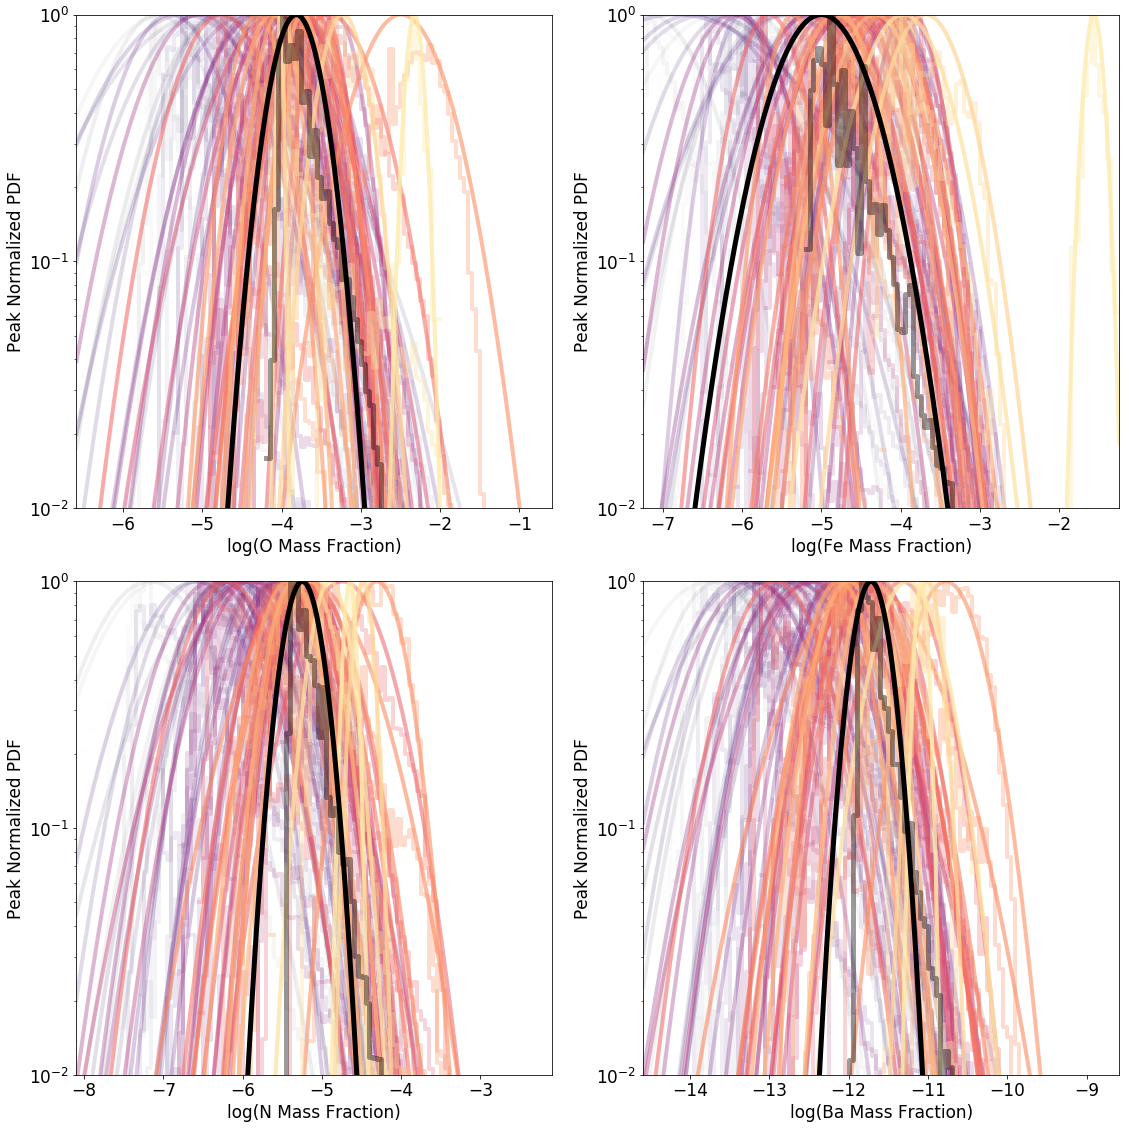

In [113]:
nrow = 2
ncol = 2

ninch = 8

fig, all_ax = plt.subplots(nrow,ncol)
fig.set_size_inches(ninch*ncol,ninch*nrow)

fbins   = data['DD0100']['Disk']['mass_fraction']['bins']
binsize =       (fbins[1:]) - (fbins[:-1])
centers = 0.5 * (fbins[1:] + fbins[:-1])

# phase = 'Molecular'
# field = 'O_Fraction'
ylim = [0.0,6]

ds_list = np.arange(80, 551, 10) # [ 100, 150, 200, 250, 300, 350]
ele = ['O','Fe','N','Ba']
phase = 'HIM'


min_median = 1.0E80
max_median = -1.0E80

axi = 0
axj = 0
phases = ['Molecular','CNM','WNM','WIM','HIM','Disk']
phase_labels = ['Molecular','Cold Neutral','Warm Neutral','Warm Ionized','Hot Ionized','All ISM']


mean_phase = {}
std_phase  = {}
actual_mean_phase = {}
actual_std_phase  = {}
time = np.zeros(np.size(ds_list))

#for k in phases:
#    mean_phase[k] = np.zeros(np.size(ds_list))
#    std_phase[k]  = np.zeros(np.size(ds_list))
#    actual_mean_phase[k] = np.zeros(np.size(ds_list))
#    actual_std_phase[k]  = np.zeros(np.size(ds_list))


def _load_data(ldata, dsname, phase, field, centers = None):
    y      = ldata[dsname][phase]['mass_fraction'][field]['hist']
    mean   = ldata[dsname][phase]['mass_fraction'][field]['mean']
    std    = ldata[dsname][phase]['mass_fraction'][field]['std']
    label  = ldata[dsname]['general']['Time'] - 46.0
    
    #if (not ('median' in ldata[dsname][phase]['mass_fraction'][field].keys())):
    median = np.log10(np.interp(0.5, np.cumsum(y)/(1.0*np.sum(y)), centers))
    #else:
    #    print 'loading median from file'
    #    median = ldata[dsname][phase]['mass_fraction'][field]['median']
        
    return y, mean, median, std, label

xmin = 10000
xmax = -1000000

plot_median = {}

D_KS_dict = {}
for e in ele:
    D_KS_dict[e] = np.zeros(np.size(ds_list))


for i,j in enumerate(ds_list):
    dsname = 'DD%0004i'%(j)
    axi = 0
    axj = 0
    for ip, element in enumerate(ele):
       # print axi, axj, phase
        if nrow == 1:
            axindex = axj
        else:
            axindex = (axi,axj)
            
        ax    = all_ax[axindex]
        field = element + '_Fraction'
        
        centers = 0.5 * (fbins[1:] + fbins[:-1])
        y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
        Mtot = data[dsname][phase]['general']['total_mass']
        
        frac   = 0.8
        alpha  = ((i / (np.size(ds_list)*1.0))) * frac
        halpha = ((i / (np.size(ds_list)*1.0))) * frac * 0.5
        color  = magma(alpha/frac) #'black' # viridis(alpha)    
        
        if j == ds_list[-1]:
            color = 'black'

        if mean is None:
            continue
            
        xplot, mean_fit, std_fit, output = _compute_fit_and_plot(ax, fbins, y, mean = mean, median = median, std = std,
                                                         alpha = alpha, halpha = halpha, color = color, Mtot=Mtot)
        print "%i %s %f %f %f"%(j, element, output['mean'], output['std'], output['D_KS'])
        
        D_KS_dict[element][i] = output['D_KS']
       
        axj = axj + 1
        
        if axj >= ncol:
            axi = axi + 1
            axj = 0

    
        min_median = np.min([median, min_median])
        max_median = np.max([median, max_median])

        xmin = np.min([np.log10(xplot[0]),xmin])
        xmax = np.max([np.log10(xplot[-1]),xmax])
        
        plot_median[element] = median
        
for i in np.arange(nrow):
    for j in np.arange(ncol):
        if nrow == 1:
            axindex = j
        else:
            axindex = (i,j)

        all_ax[axindex].set_xlim(xmax - 5, xmax)
        all_ax[axindex].semilogy()
        all_ax[axindex].set_ylim(1.0E-2,1.0)

        ba =  8
        ba = 0
        # all_ax[axindex].set_xlim(-7 - ba, -2.5 - ba)   

        # xy = (np.min(all_ax[axindex].get_xlim())+ 0.2,np.max(all_ax[axindex].get_ylim())*0.95)
        # all_ax[axindex].annotate(phase_labels[(3)*(i) + j], xy = xy, xytext=xy)
        all_ax[axindex].set_ylabel(r'Peak Normalized PDF')
    #ax.set_xlim( np.log10(min_median) - 2, np.log10(max_median) + 2)

count = 0
for i in np.arange(nrow):
    for j in np.arange(ncol):
        if nrow == 1:
            axindex = j
        else:
            axindex = (i,j)
        e = ele[count]
        all_ax[axindex].set_xlim(  plot_median[e] - 3, plot_median[e] + 3)
        all_ax[axindex].set_xlabel(r'log(' + e +' Mass Fraction)')
        count = count + 1

#ax[(0,0)].set_xlim(
#ax[(0,0)].

#fig.savefig(field + '_phase_evolution.png')
plt.tight_layout()
fig.savefig('lognorm_O_Fe_N_Ba.png')

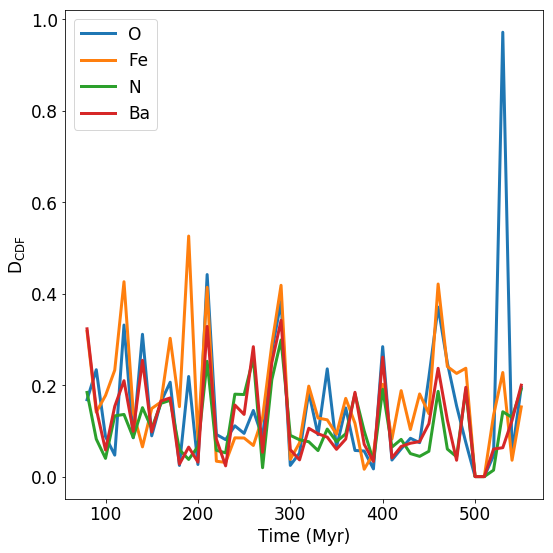

In [114]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
for e in ele:
    ax.plot(ds_list, D_KS_dict[e], lw = 3, label = e)
ax.set_xlabel('Time (Myr)')
ax.set_ylabel(r'D$_{\rm CDF}$')
plt.tight_layout()
ax.legend(loc = 'best')

['C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
['Ba', 'Y', 'As', 'Sr', 'Mn', 'Na', 'Ca', 'N', 'Ni', 'Mg', 'S', 'Si', 'Fe', 'C', 'O']


/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in log


Ba 0.1769833224 0.510162043943 0.0706161510268 0.784435694473
Y 0.17894146557 0.495428957618 0.0792009272515 0.653933336746
As 0.243820211582 0.156519253148 0.0646955888689 0.873484384921
Sr 0.279200602969 0.0717326381985 0.117296394018 0.173277379859
Mn 0.250044176385 0.13752559694 0.0612070060374 0.911376353017
Na 0.198146033987 0.365525926152 0.0574854976791 0.941474045999
Ca 0.193863242131 0.392217304679 0.070281627131 0.806874705177
N 0.295250507662 0.0485537450736 0.0596282901553 0.929443703587
Ni 0.339448671822 0.0146941031136 0.0556732072131 0.943032853915
Mg 0.163527509675 0.618719295939 0.0527615196232 0.976412067738
S 0.257977454803 0.116053166515 0.0737921104416 0.772097190861
Si 0.123492031837 0.92051556148 0.0530716844275 0.975025365224
Fe 0.169946107713 0.565365850778 0.0500511347707 0.984462930174
C 0.273432464381 0.0820733649829 0.0718919222222 0.796601649057
O 0.192838567832 0.398795248423 0.0586083471431 0.9380148795


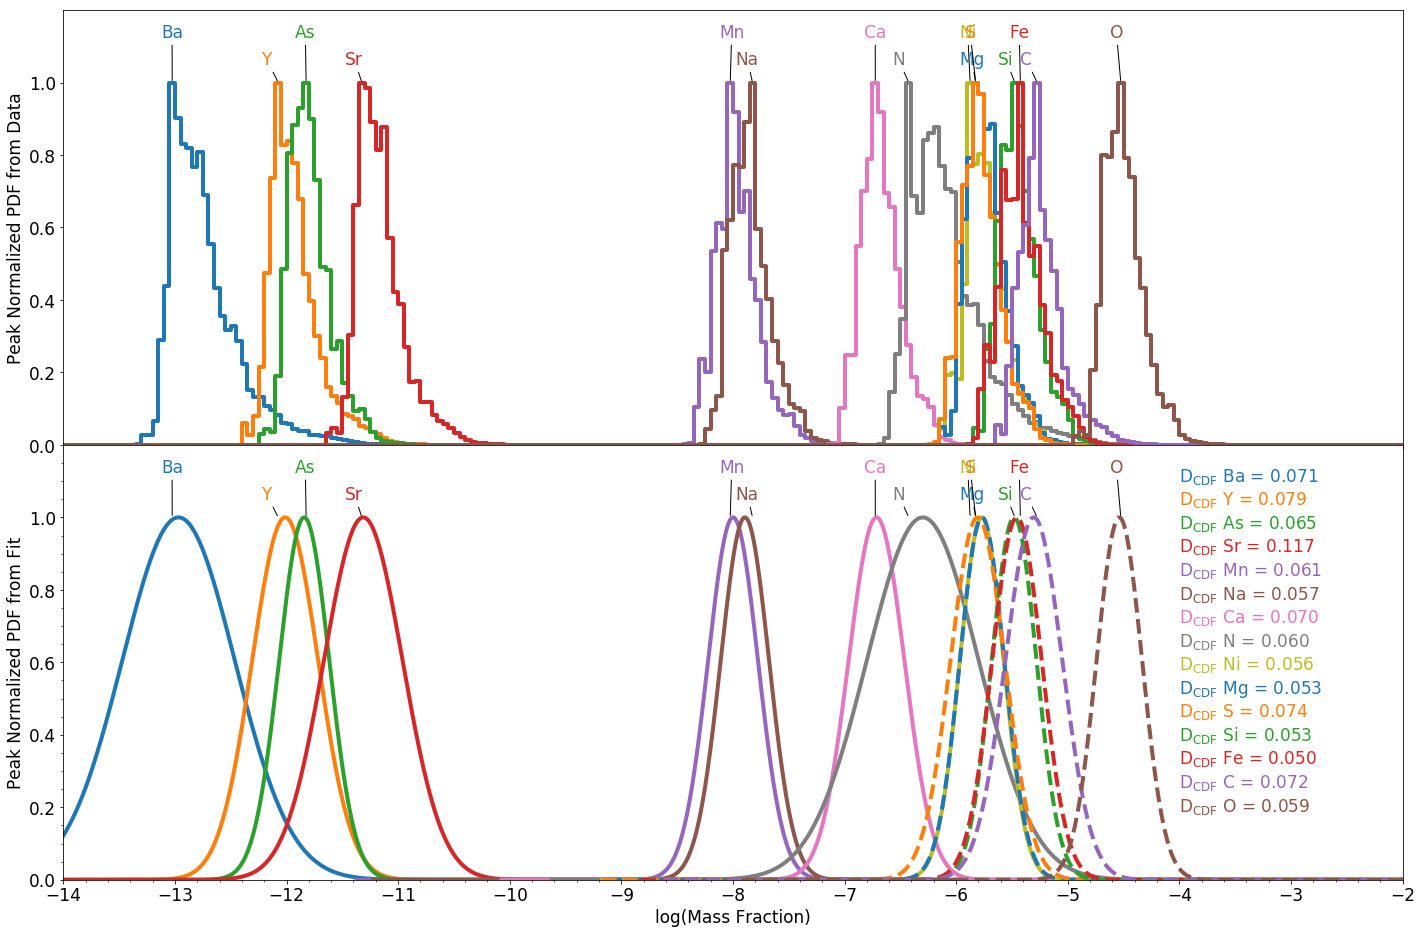

In [42]:
fig, ax = plt.subplots(2)
fig.set_size_inches(24,16)

ds_num = 400
dsname = 'DD%0004i'%(ds_num)

fbins   = data[dsname]['Disk']['mass_fraction']['bins']
binsize =       (fbins[1:]) - (fbins[:-1])
centers = 0.5 * (fbins[1:] + fbins[:-1])
# phase = 'Molecular'
# field = 'O_Fraction'

keys = data[dsname]['Disk']['mass_fraction'].keys()
keys = [k.split('_F')[0] for k in keys if '_Fraction' in k]
keys = [k for k in keys if len(k) <= 2]
elements = utilities.sort_by_anum([k for k in keys if not k in ['H','He','H1','H2']])
print elements
elements = ['Ba','Y','As','Sr','Mn','Na','Ca','N','Ni','Mg','S','Si','Fe','C','O']
print elements

def _load_data(ldata, dsname, phase, field, centers = None):
    y      = ldata[dsname][phase]['mass_fraction'][field]['hist']
    mean   = ldata[dsname][phase]['mass_fraction'][field]['mean']
    std    = ldata[dsname][phase]['mass_fraction'][field]['std']
    label  = ldata[dsname]['general']['Time'] - 46.0
    
    #if (not ('median' in ldata[dsname][phase]['mass_fraction'][field].keys())):
    median = np.log10(np.interp(0.5, np.cumsum(y)/(1.0*np.sum(y)), centers))
    #else:
    #    print 'loading median from file'
    #    median = ldata[dsname][phase]['mass_fraction'][field]['median']
        
    return y, mean, median, std, label


plot_log = False # True

xmin = 10000
xmax = -1000000

colors = ['C' + str(i) for i in np.arange(9)]
lss     = ['-','--']
ci = li = 0

xprev = -1000
plot_median = {}


ymax_order = np.zeros(np.size(elements))
phase = 'Disk'    
for i, e in enumerate(elements):
    field = e + '_Fraction'
    y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
    ymax_order[i] = np.argmax(y/binsize)
    
sort = np.argsort(ymax_order)
sort_e = np.array(elements)[sort]

label_pos = np.empty((np.size(elements),))
label_pos[::2] = 1
label_pos[1::2] = -1

label_pos = label_pos[sort]
#print sort_e
xychi_y = 1.1
for i, e in enumerate(elements):
    dsname = 'DD%0004i'%(ds_num)
    
    field = e + '_Fraction'
        
    centers = 0.5 * (fbins[1:] + fbins[:-1])
    y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
        
    frac   = 0.8
    alpha = halpha = 1.0
    # alpha  = ((i / (np.size(elements)*1.0))) * frac
    # halpha = ((i / (np.size(elements)*1.0))) * frac * 0.5
    # color  = magma(i/(1.0*np.size(elements))) #'black' # viridis(alpha)    
    
    color = colors[ci]
    ls    = lss[li]
    Mtot = data[dsname][phase]['general']['total_mass']

    _compute_fit_and_plot(ax[0], fbins, y,
                                                     alpha = alpha, halpha = halpha, color = color, Mtot=Mtot)
    
    xplot, mean_fit, std_fit, output = _compute_fit_and_plot(ax[1], fbins, y, mean = mean, median = median, std = std,
                                                     alpha = alpha, halpha = halpha, color = color, show_hist = False, ls = ls, Mtot = Mtot, method = "KS")
    #print "%s %i %f %f %f %f"%(e, output['N'], output['mean'], output['std'], output['chisqr'], output['rchisqr'])
    print e, output['KS_result'][0], output['KS_result'][1], output['D_KS'], output['KS_pval']
    
    #ax[2].plot(np.log10(output['fit_x']), output['rel_error'], lw = 3, color = color)
    
    #if e == 'Mn':
    #    print y
    
    if plot_log:
        ytext = 4.0
    else:
        ytext = 1.05
    
    xtext = np.log10(centers[np.argmax(y/binsize)]) - 0.1 - 0.05
    xa    = np.log10(centers[np.argmax(y/binsize)])
    ya    = 1.0
    
    pos = label_pos[i]
    
    #if np.abs(xtext -xprev) < 0.2:
    if pos > 0:
        xtext = xtext + 0.05
        if plot_log:
            ytext = 2.0
            
        else:
            ytext = 1.125
    # pos   = pos * -1
        
    
    xy = (xtext, ytext)
    xya = (xa,ya)
    
    ax[0].annotate(e, xy = xya, xytext=xy, color = color, 
                   arrowprops=dict(arrowstyle="-", connectionstyle="arc3"))
    ax[1].annotate(e, xy = xya, xytext=xy, color = color, 
                   arrowprops=dict(arrowstyle="-",connectionstyle="arc3"))
    
    xychi = (-4, xychi_y)
    ax[1].annotate(r'D$_{\rm CDF}$ ' + e + ' = %0.3f'%(output['D_KS']),
                   xy = xychi, xytext=xychi, color = color)
    xychi_y = xychi_y - 0.065  # *10.0**(-0.34)

    
    xprev = xy[0]
        
    ci = ci + 1
    if ci >= np.size(colors):
        ci = 0
        li = li + 1
        
for i in [0,1]:
    ax[i].set_xlim(xmax - 5, xmax)
    if plot_log:
        ax[i].semilogy()
        ax[i].set_ylim(1.0E-5,8.0)
        ax[i].set_xlim(-14,-1.5)
        ax[i].set_xticks(np.arange(-14,-1))
    else:
        ax[i].set_ylim(0.0,1.2)
        ax[i].set_xlim(-14,-2)
        ax[i].set_xticks(np.arange(-14,-1))
        ax[i].set_yticks(np.arange(0,11,2)/10.0)
        
    ax[i].set_xlabel(r'log(Mass Fraction)')

#ax[2].set_ylabel('Normalized Error')
#ax[2].set_xlim(ax[1].get_xlim())
#ax[2].semilogy()

ax[0].set_ylabel('Peak Normalized PDF from Data')
ax[1].set_ylabel('Peak Normalized PDF from Fit')
    
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.minorticks_on()
#ax[(0,0)].set_xlim(
#ax[(0,0)].

#fig.savefig(field + '_phase_evolution.png')
#plt.tight_layout()
outname = 'lognorm_all_elements_' + phase + '_400.png'
if plot_log:
    outname = 'log_' + outname
fig.savefig(outname)



['C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
['Ba', 'Y', 'As', 'Sr', 'Mn', 'Na', 'Ca', 'N', 'Ni', 'Mg', 'S', 'Si', 'Fe', 'C', 'O']


/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in log


N 0.0847269571722 0.923724361058 -5.70180176873
N 0.0519286687527 0.993615927421 -5.27899614049
N 0.0528443428368 0.97604697421 -5.13568677079
N 0.0600078378056 0.929295902778 -5.05823654518
N 0.0744502814568 0.82616379794 -4.68035213786
O 0.0854253580414 0.999079843382 -4.49544425079
O 0.0527382498611 0.999912503987 -4.32239882141
O 0.0440835703469 0.999698758837 -4.20403549172
O 0.0533693937267 0.978028597724 -3.8702601472
O 0.0840728769639 0.619817294083 -2.68541851937


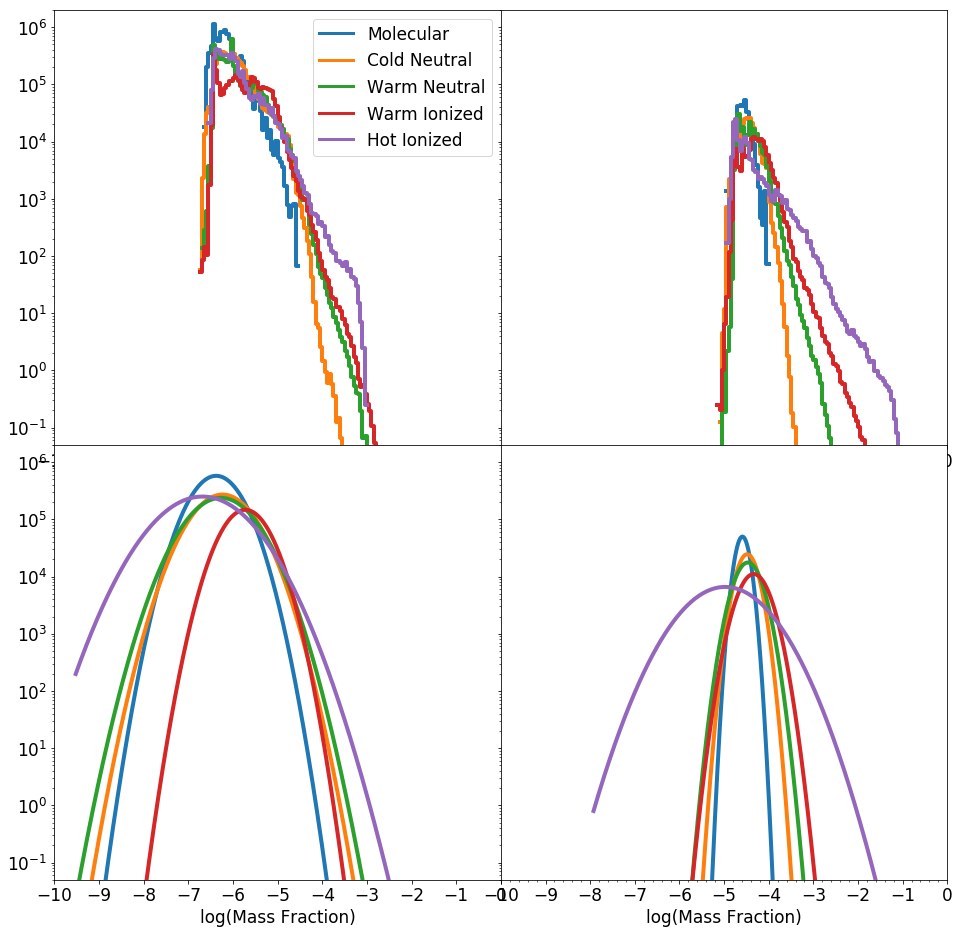

In [16]:
fig, ax = plt.subplots(2,2, sharey=True) #, sharex=True)
fig.set_size_inches(16,16)

ds_num = 400
dsname = 'DD%0004i'%(ds_num)

fbins   = data[dsname]['Disk']['mass_fraction']['bins']
binsize =       (fbins[1:]) - (fbins[:-1])
centers = 0.5 * (fbins[1:] + fbins[:-1])
# phase = 'Molecular'
# field = 'O_Fraction'

keys = data[dsname]['Disk']['mass_fraction'].keys()
keys = [k.split('_F')[0] for k in keys if '_Fraction' in k]
keys = [k for k in keys if len(k) <= 2]
elements = utilities.sort_by_anum([k for k in keys if not k in ['H','He','H1','H2']])
print elements
elements = ['Ba','Y','As','Sr','Mn','Na','Ca','N','Ni','Mg','S','Si','Fe','C','O']
print elements

def _load_data(ldata, dsname, phase, field, centers = None):
    y      = ldata[dsname][phase]['mass_fraction'][field]['hist']
    mean   = ldata[dsname][phase]['mass_fraction'][field]['mean']
    std    = ldata[dsname][phase]['mass_fraction'][field]['std']
    label  = ldata[dsname]['general']['Time'] - 46.0
    
    #if (not ('median' in ldata[dsname][phase]['mass_fraction'][field].keys())):
    median = np.log10(np.interp(0.5, np.cumsum(y)/(1.0*np.sum(y)), centers))
    #else:
    #    print 'loading median from file'
    #    median = ldata[dsname][phase]['mass_fraction'][field]['median']
        
    return y, mean, median, std, label


plot_log = True

xmin = 10000
xmax = -1000000

colors = ['C' + str(i) for i in np.arange(9)]
lss     = ['-','--']
ci = li = 0

xprev = -1000
plot_median = {}


ymax_order = np.zeros(np.size(elements))
phase = 'Disk'    
for i, e in enumerate(elements):
    field = e + '_Fraction'
    y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
    ymax_order[i] = np.argmax(y/binsize)
    
sort = np.argsort(ymax_order)
sort_e = np.array(elements)[sort]

label_pos = np.empty((np.size(elements),))
label_pos[::2] = 1
label_pos[1::2] = -1

label_pos = label_pos[sort]
#print sort_e
xychi_y = 1.1

colors = {'Molecular':'C0','CNM':'C1','WNM':'C2','WIM':'C3','HIM':'C4'}
lss = {'O' : '-', 'N' : '-'}

xs = {'O': 0.0, 'N' : 0.0}

for i, e in enumerate(['N','O']):
    x_shift = xs[e]
    for phase in ['Molecular','CNM','WNM','WIM','HIM']:
        dsname = 'DD%0004i'%(ds_num)
    
        field = e + '_Fraction'
        
        centers = 0.5 * (fbins[1:] + fbins[:-1])
        y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
        
        frac   = 0.8
        alpha = halpha = 1.0
    # alpha  = ((i / (np.size(elements)*1.0))) * frac
    # halpha = ((i / (np.size(elements)*1.0))) * frac * 0.5
    # color  = magma(i/(1.0*np.size(elements))) #'black' # viridis(alpha)    
    
        color = colors[phase]
        ls    = lss[e]
        Mtot = data[dsname][phase]['general']['total_mass']

        _compute_fit_and_plot(ax[(0,i)], fbins, y, x_shift = x_shift,
                                                         alpha = alpha, halpha = halpha, color = color, Mtot=Mtot, peak_normalize = False)
    
        xplot, mean_fit, std_fit, output = _compute_fit_and_plot(ax[(1,i)], fbins, y, mean = mean, median = median, std = std,
                                                     alpha = alpha, halpha = halpha, color = color, show_hist = False, ls = ls,
                                                     Mtot = Mtot, method = "KS", x_shift = x_shift, peak_normalize = False)
        #print "%s %i %f %f %f %f"%(e, output['N'], output['mean'], output['std'], output['chisqr'], output['rchisqr'])
        print e,  output['D_KS'], output['KS_pval'], np.log10(output['num_pdf_mean'])
    
    #ax[2].plot(np.log10(output['fit_x']), output['rel_error'], lw = 3, color = color)
    
    #if e == 'Mn':
    #    print y
    
        if plot_log:
            ytext = 4.0
        else:
            ytext = 1.05
    
        xtext = np.log10(centers[np.argmax(y/binsize)]) - 0.1 - 0.05
        xa    = np.log10(centers[np.argmax(y/binsize)])
        ya    = 1.0
    
        pos = label_pos[i]
    
        #if np.abs(xtext -xprev) < 0.2:
        if pos > 0:
            xtext = xtext + 0.05
            if plot_log:
                ytext = 2.0
            
            else:
                ytext = 1.125
    # pos   = pos * -1
        
    
        xy = (xtext, ytext)
        xya = (xa,ya)
    
#        ax[0].annotate(e, xy = xya, xytext=xy, color = color, 
#                       arrowprops=dict(arrowstyle="-", connectionstyle="arc3"))
#        ax[1].annotate(e, xy = xya, xytext=xy, color = color, 
#                       arrowprops=dict(arrowstyle="-",connectionstyle="arc3"))
    
        xychi = (-4, xychi_y)
#        ax[1].annotate(r'D$_{\rm CDF}$ ' + e + ' = %0.3f'%(output['D_KS']),
#                       xy = xychi, xytext=xychi, color = color)
        
        xychi_y = xychi_y - 0.065  # *10.0**(-0.34)

    
        xprev = xy[0]
        
        ci = ci + 1
        if ci >= np.size(colors):
            ci = 0
            li = li + 1
        
for i in [(0,0),(0,1),(1,0),(1,1)]:
    ax[i].set_xlim(xmax - 5, xmax)
    if plot_log:
        ax[i].semilogy()
        ax[i].set_ylim(5.0E-2, 2.0E6)
        xmin = -9.5
        xmax = -0.9
        ax[i].set_xlim(xmin,xmax)
        ax[i].set_xticks(np.arange(np.floor(xmin),np.ceil(xmax)+0.5))

    else:
        ax[i].set_ylim(0.0,1.2)
        ax[i].set_xlim(-14.1,-1.9)
        ax[i].set_xticks(np.arange(-14,-1))
        ax[i].set_yticks(np.arange(0,11,2)/10.0)
    
    ax[i].set_xlabel(r'log(Mass Fraction)')

labels = {'Molecular' : 'Molecular', 'CNM' : "Cold Neutral", 'WNM' :"Warm Neutral", "WIM" : "Warm Ionized", "HIM" : 'Hot Ionized'}
    
for phase in phases:
    if phase == 'Disk':
        continue
    ax[(0,0)].plot([-1000,-999],[1,2], lw = 3, color = colors[phase], ls = '-', label = labels[phase])
#ax[2].set_ylabel('Normalized Error')
#ax[2].set_xlim(ax[1].get_xlim())
#ax[2].semilogy()

#ax[0].set_ylabel('Peak Normalized PDF from Data')
#ax[1].set_ylabel('Peak Normalized PDF from Fit')
#plt.subplots_adjust(wspace=None, hspace=None)    
fig.subplots_adjust(wspace = 0, hspace=0)

#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.minorticks_on()
#ax[(0,0)].set_xlim(
#ax[(0,0)].
ax[(0,0)].legend(loc='best')

#fig.savefig(field + '_phase_evolution.png')
#plt.tight_layout()
outname = 'lognorm_select_elements_all_phases_400.png'
if plot_log:
    outname = 'log_' + outname
fig.savefig(outname)



['C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
['Ba', 'Y', 'As', 'Sr', 'Mn', 'Na', 'Ca', 'N', 'Ni', 'Mg', 'S', 'Si', 'Fe', 'C', 'O']


/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in log


O 0.0854253580414 0.999079843382 -4.49544425079
O 0.0527382498611 0.999912503987 -4.32239882141
O 0.0440835703469 0.999698758837 -4.20403549172
O 0.0533693937267 0.978028597724 -3.8702601472
O 0.0840728769639 0.619817294083 -2.68541851937
Ba 0.0780804775434 0.951307668723 -12.3596829112
Ba 0.0680544300992 0.897382283968 -11.9068399228
Ba 0.0606283509277 0.913530169489 -11.7282137025
Ba 0.0550393310487 0.958987668616 -11.62596031
Ba 0.0693280723053 0.847604442798 -11.0714945705


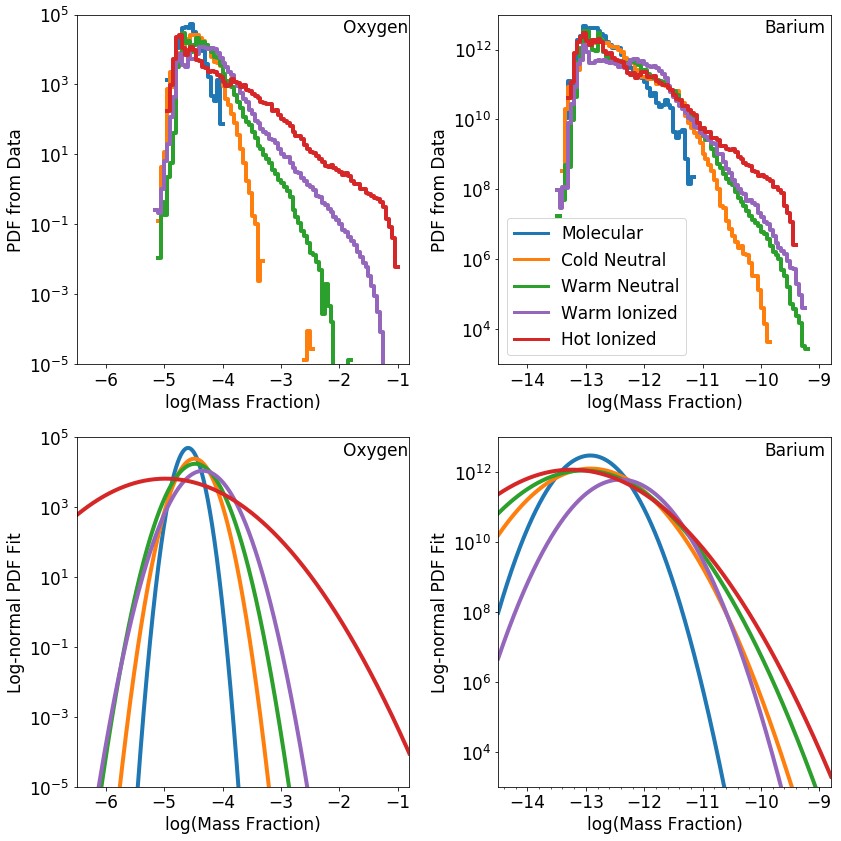

In [49]:
fig, ax = plt.subplots(2,2) #, sharey=True) #, sharex=True)
fig.set_size_inches(12,12)

ds_num = 400
dsname = 'DD%0004i'%(ds_num)

fbins   = data[dsname]['Disk']['mass_fraction']['bins']
binsize =       (fbins[1:]) - (fbins[:-1])
centers = 0.5 * (fbins[1:] + fbins[:-1])
# phase = 'Molecular'
# field = 'O_Fraction'

keys = data[dsname]['Disk']['mass_fraction'].keys()
keys = [k.split('_F')[0] for k in keys if '_Fraction' in k]
keys = [k for k in keys if len(k) <= 2]
elements = utilities.sort_by_anum([k for k in keys if not k in ['H','He','H1','H2']])
print elements
elements = ['Ba','Y','As','Sr','Mn','Na','Ca','N','Ni','Mg','S','Si','Fe','C','O']
print elements

def _load_data(ldata, dsname, phase, field, centers = None):
    y      = ldata[dsname][phase]['mass_fraction'][field]['hist']
    mean   = ldata[dsname][phase]['mass_fraction'][field]['mean']
    std    = ldata[dsname][phase]['mass_fraction'][field]['std']
    label  = ldata[dsname]['general']['Time'] - 46.0
    
    #if (not ('median' in ldata[dsname][phase]['mass_fraction'][field].keys())):
    median = np.log10(np.interp(0.5, np.cumsum(y)/(1.0*np.sum(y)), centers))
    #else:
    #    print 'loading median from file'
    #    median = ldata[dsname][phase]['mass_fraction'][field]['median']
        
    return y, mean, median, std, label


plot_log = True

xmin = 10000
xmax = -1000000

colors = ['C' + str(i) for i in np.arange(9)]
lss     = ['-','--']
ci = li = 0

xprev = -1000
plot_median = {}


ymax_order = np.zeros(np.size(elements))
phase = 'Disk'    
for i, e in enumerate(elements):
    field = e + '_Fraction'
    y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
    ymax_order[i] = np.argmax(y/binsize)
    
sort = np.argsort(ymax_order)
sort_e = np.array(elements)[sort]

label_pos = np.empty((np.size(elements),))
label_pos[::2] = 1
label_pos[1::2] = -1

label_pos = label_pos[sort]
#print sort_e
xychi_y = 1.1

colors = {'Molecular':'C0','CNM':'C1','WNM':'C2','WIM':'C4','HIM':'C3'}
lss = {'O' : '-', 'Ba' : '-'}

xs = {'O': 0.0, 'Ba' : 0.0}

for i, e in enumerate(['O','Ba']):
    x_shift = xs[e]
    for phase in ['Molecular','CNM','WNM','WIM','HIM']:
        dsname = 'DD%0004i'%(ds_num)
    
        field = e + '_Fraction'
        
        centers = 0.5 * (fbins[1:] + fbins[:-1])
        y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
        
        frac   = 0.8
        alpha = halpha = 1.0
    # alpha  = ((i / (np.size(elements)*1.0))) * frac
    # halpha = ((i / (np.size(elements)*1.0))) * frac * 0.5
    # color  = magma(i/(1.0*np.size(elements))) #'black' # viridis(alpha)    
    
        color = colors[phase]
        ls    = lss[e]
        Mtot = data[dsname][phase]['general']['total_mass']

        _compute_fit_and_plot(ax[(0,i)], fbins, y, x_shift = x_shift,
                                                         alpha = alpha, halpha = halpha, color = color, Mtot=Mtot, peak_normalize = False, plot_CDF=False)
    
        xplot, mean_fit, std_fit, output = _compute_fit_and_plot(ax[(1,i)], fbins, y, mean = mean, median = median, std = std,
                                                     alpha = alpha, halpha = halpha, color = color, show_hist = False, ls = ls,
                                                     Mtot = Mtot, method = "KS", x_shift = x_shift, peak_normalize = False, plot_CDF = False)
        #print "%s %i %f %f %f %f"%(e, output['N'], output['mean'], output['std'], output['chisqr'], output['rchisqr'])
        print e,  output['D_KS'], output['KS_pval'], np.log10(output['num_pdf_mean'])
    
    #ax[2].plot(np.log10(output['fit_x']), output['rel_error'], lw = 3, color = color)
    
    #if e == 'Mn':
    #    print y
    
        if plot_log:
            ytext = 4.0
        else:
            ytext = 1.05
    
        xtext = np.log10(centers[np.argmax(y/binsize)]) - 0.1 - 0.05
        xa    = np.log10(centers[np.argmax(y/binsize)])
        ya    = 1.0
    
        pos = label_pos[i]
    
        #if np.abs(xtext -xprev) < 0.2:
        if pos > 0:
            xtext = xtext + 0.05
            if plot_log:
                ytext = 2.0
            
            else:
                ytext = 1.125
    # pos   = pos * -1
        
    
        xy = (xtext, ytext)
        xya = (xa,ya)
    
#        ax[0].annotate(e, xy = xya, xytext=xy, color = color, 
#                       arrowprops=dict(arrowstyle="-", connectionstyle="arc3"))
#        ax[1].annotate(e, xy = xya, xytext=xy, color = color, 
#                       arrowprops=dict(arrowstyle="-",connectionstyle="arc3"))
    
        xychi = (-4, xychi_y)
#        ax[1].annotate(r'D$_{\rm CDF}$ ' + e + ' = %0.3f'%(output['D_KS']),
#                       xy = xychi, xytext=xychi, color = color)
        
        xychi_y = xychi_y - 0.065  # *10.0**(-0.34)

    
        xprev = xy[0]
        
        ci = ci + 1
        if ci >= np.size(colors):
            ci = 0
            li = li + 1
        
for i in [(0,0),(0,1),(1,0),(1,1)]:
    ax[i].set_xlim(xmax - 5, xmax)
    
    # ax[i].set_ylim(, 1.0)
    #xmin = -7.5
    #xmax = -1.8
    #ax[i].set_xlim(xmin,xmax)
    ##ax[i].set_xticks(np.arange(np.floor(xmin),np.ceil(xmax)+0.5))

    
    ax[i].set_xlabel(r'log(Mass Fraction)')
    
    if plot_log:
        ax[i].semilogy()
    
for i in [0,1]:
    
    ax[(i,0)].set_xlim(-6.5 , -0.8)
    ax[(i,1)].set_xlim(-14.5,  -8.8)
    ax[(i,0)].set_ylim(1.0E-5, 1.0E5)
    ax[(i,1)].set_ylim(1.0E3, 1.0E13)

labels = {'Molecular' : 'Molecular', 'CNM' : "Cold Neutral", 'WNM' :"Warm Neutral", "WIM" : "Warm Ionized", "HIM" : 'Hot Ionized'}
    
for phase in phases:
    if phase == 'Disk':
        continue
    ax[(0,0)].plot([-1000,-999],[1,2], lw = 3, color = colors[phase], ls = '-', label = labels[phase])
    ax[(0,1)].plot([-1000,-999],[1,2], lw = 3, color = colors[phase], ls = '-', label = labels[phase])

#ax[2].set_ylabel('Normalized Error')
#ax[2].set_xlim(ax[1].get_xlim())
ax[(0,1)].legend(loc='lower left')


xfrac = 0.8
yfrac = 0.95
for i in [0,1]:
    xlim = ax[(i,0)].get_xlim()
    ylim = ax[(i,0)].get_ylim()
    xy = ( xfrac*(xlim[1]-xlim[0])+xlim[0], 10.0**(yfrac*(np.log10(ylim[1])-np.log10(ylim[0])) + np.log10(ylim[0])) )
    ax[(i,0)].annotate('Oxygen', xy, xy)
    xlim = ax[(i,1)].get_xlim()
    ylim = ax[(i,1)].get_ylim()
    xy = ( xfrac*(xlim[1]-xlim[0])+xlim[0], 10.0**(yfrac*(np.log10(ylim[1])-np.log10(ylim[0])) + np.log10(ylim[0])) )
    ax[(i,1)].annotate('Barium', xy, xy)


ax[(0,0)].set_ylabel('PDF from Data')
ax[(1,0)].set_ylabel('Log-normal PDF Fit')
ax[(0,1)].set_ylabel('PDF from Data')
ax[(1,1)].set_ylabel('Log-normal PDF Fit')
# plt.subplots_adjust(wspace=None, hspace=None)    
# fig.subplots_adjust(wspace = 0, hspace=0)

#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.minorticks_on()
#ax[(0,0)].set_xlim(
#ax[(0,0)].
plt.tight_layout()
#fig.savefig(field + '_phase_evolution.png')
#plt.tight_layout()
outname = 'lognorm_select_elements_all_phases_400.png'
if plot_log:
    outname = 'log_' + outname
fig.savefig(outname)



['C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
['Ba', 'Y', 'As', 'Sr', 'Mn', 'Na', 'Ca', 'N', 'Ni', 'Mg', 'S', 'Si', 'Fe', 'C', 'O']


/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in log


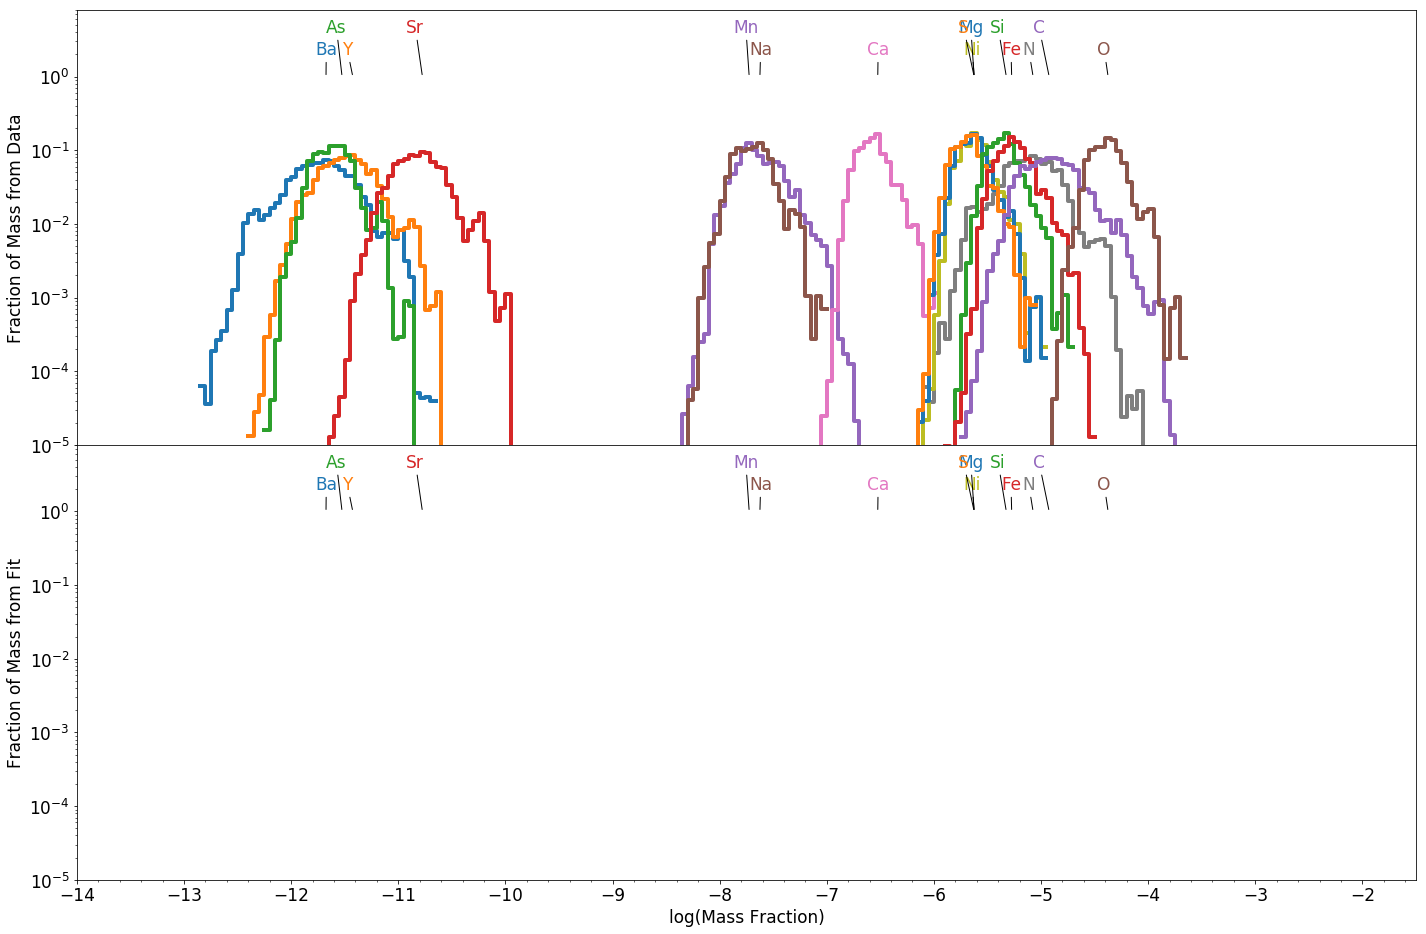

In [14]:
fig, ax = plt.subplots(2)
fig.set_size_inches(24,16)

fbins   = data[dsname]['Disk']['mass_fraction']['bins']
binsize =       (fbins[1:]) - (fbins[:-1])
centers = 0.5 * (fbins[1:] + fbins[:-1])
# phase = 'Molecular'
# field = 'O_Fraction'

keys = data[dsname]['Disk']['mass_fraction'].keys()
keys = [k.split('_F')[0] for k in keys if '_Fraction' in k]
keys = [k for k in keys if len(k) <= 2]
elements = utilities.sort_by_anum([k for k in keys if not k in ['H','He','H1','H2']])
print elements
elements = ['Ba','Y','As','Sr','Mn','Na','Ca','N','Ni','Mg','S','Si','Fe','C','O']
print elements

def _load_data(ldata, dsname, phase, field, centers = None):
    y      = ldata[dsname][phase]['mass_fraction'][field]['hist']
    mean   = ldata[dsname][phase]['mass_fraction'][field]['mean']
    std    = ldata[dsname][phase]['mass_fraction'][field]['std']
    label  = ldata[dsname]['general']['Time'] - 46.0
    
    #if (not ('median' in ldata[dsname][phase]['mass_fraction'][field].keys())):
    median = np.log10(np.interp(0.5, np.cumsum(y)/(1.0*np.sum(y)), centers))
    #else:
    #    print 'loading median from file'
    #    median = ldata[dsname][phase]['mass_fraction'][field]['median']
        
    return y, mean, median, std, label


plot_log = True

xmin = 10000
xmax = -1000000

colors = ['C' + str(i) for i in np.arange(9)]
lss     = ['-','--']
ci = li = 0

xprev = -1000
plot_median = {}


ymax_order = np.zeros(np.size(elements))
phase = 'CNM'    
for i, e in enumerate(elements):
    field = e + '_Fraction'
    y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
    ymax_order[i] = np.argmax(y/binsize)
    
sort = np.argsort(ymax_order)
sort_e = np.array(elements)[sort]

label_pos = np.empty((np.size(elements),))
label_pos[::2] = 1
label_pos[1::2] = -1

label_pos = label_pos[sort]
#print sort_e
    

for i, e in enumerate(elements):
    dsname = 'DD%0004i'%(ds_num)
    
    field = e + '_Fraction'
        
    centers = 0.5 * (fbins[1:] + fbins[:-1])
    y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
        
    frac   = 0.8
    alpha = halpha = 1.0
    # alpha  = ((i / (np.size(elements)*1.0))) * frac
    # halpha = ((i / (np.size(elements)*1.0))) * frac * 0.5
    # color  = magma(i/(1.0*np.size(elements))) #'black' # viridis(alpha)    
    
    color = colors[ci]
    ls    = lss[li]

    _compute_fit_and_plot(ax[0], fbins, y, plot_PDF = False,
                                                     alpha = alpha, halpha = halpha, color = color)
    
    xplot, mean_fit, std_fit, output = _compute_fit_and_plot(ax[1], fbins, y, mean = mean, median = median, std = std, plot_PDF = False,
                                                     alpha = alpha, halpha = halpha, color = color, show_hist = False, ls = ls)
    
    if plot_log:
        ytext = 4.0
    else:
        ytext = 1.05
    
    xtext = np.log10(centers[np.argmax(y)]) - 0.1 - 0.05
    xa    = np.log10(centers[np.argmax(y)])
    ya    = 1.0
    
    pos = label_pos[i]
    
    #if np.abs(xtext -xprev) < 0.2:
    if pos > 0:
        xtext = xtext + 0.05
        if plot_log:
            ytext = 2.0
            
        else:
            ytext = 1.125
    # pos   = pos * -1
        
    
    xy = (xtext, ytext)
    xya = (xa,ya)
    
    ax[0].annotate(e, xy = xya, xytext=xy, color = color, 
                   arrowprops=dict(arrowstyle="-", connectionstyle="arc3"))
    ax[1].annotate(e, xy = xya, xytext=xy, color = color, 
                   arrowprops=dict(arrowstyle="-",connectionstyle="arc3"))
    xprev = xy[0]
        
    ci = ci + 1
    if ci >= np.size(colors):
        ci = 0
        li = li + 1
        
for i in [0,1]:
    ax[i].set_xlim(xmax - 5, xmax)
    if plot_log:
        ax[i].semilogy()
        ax[i].set_ylim(1.0E-5,8.0)
        ax[i].set_xlim(-14,-1.5)
        ax[i].set_xticks(np.arange(-14,-1))
    else:
        ax[i].set_ylim(0.0,0.15)
        ax[i].set_xlim(-14,-2)
        ax[i].set_xticks(np.arange(-14,-1))
        ax[i].set_yticks(np.arange(0,1.5,0.2)/10.0)
        
    ax[i].set_xlabel(r'log(Mass Fraction)')


ax[0].set_ylabel('Fraction of Mass from Data')
ax[1].set_ylabel('Fraction of Mass from Fit')
    
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.minorticks_on()
#ax[(0,0)].set_xlim(
#ax[(0,0)].

#fig.savefig(field + '_phase_evolution.png')
#plt.tight_layout()
outname = 'lognorm_int_all_elements_' + phase + '.png'
if plot_log:
    outname = 'log_' + outname
fig.savefig(outname)



['C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
['Ba', 'Y', 'As', 'Sr', 'Mn', 'Na', 'Ca', 'N', 'Ni', 'Mg', 'S', 'Si', 'Fe', 'C', 'O']


/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in log


Ba 0.0439947093713 -26.1313262119 0.867377084079 0.999751858649
Y 0.0526760406519 -24.8224874527 0.733774163908 0.999220719905
As 0.0406930269413 -23.9945842276 0.624079504462 0.999999969454
Sr 0.0537610625561 -23.0834393382 0.75155860821 0.999472159243
Mn 0.043657156183 -14.5211307112 0.704143589476 0.999988469115
Na 0.051673783293 -15.5757183898 0.73721762206 0.999944378187
Ca 0.0446876426895 -11.5853191178 0.7126418575 0.999979168633
N 0.0482414117162 -11.1452842789 0.99201808917 0.99835827165
Ni 0.0357104879674 -9.49828358293 0.688512924385 0.999999997009
Mg 0.0414101534904 -10.058692408 0.643597642257 0.999999941153
S 0.0445555084233 -9.62239853634 0.690049492726 0.999988739042
Si 0.0420580556799 -8.9718427626 0.665815611863 0.999998826507
Fe 0.0373884194496 -8.44650272877 0.829402941317 0.99999979526
C 0.0310755117868 -8.57895241934 0.637802664695 0.999999999998
O 0.0395613626932 -7.29793091498 0.639311476762 0.999999989928


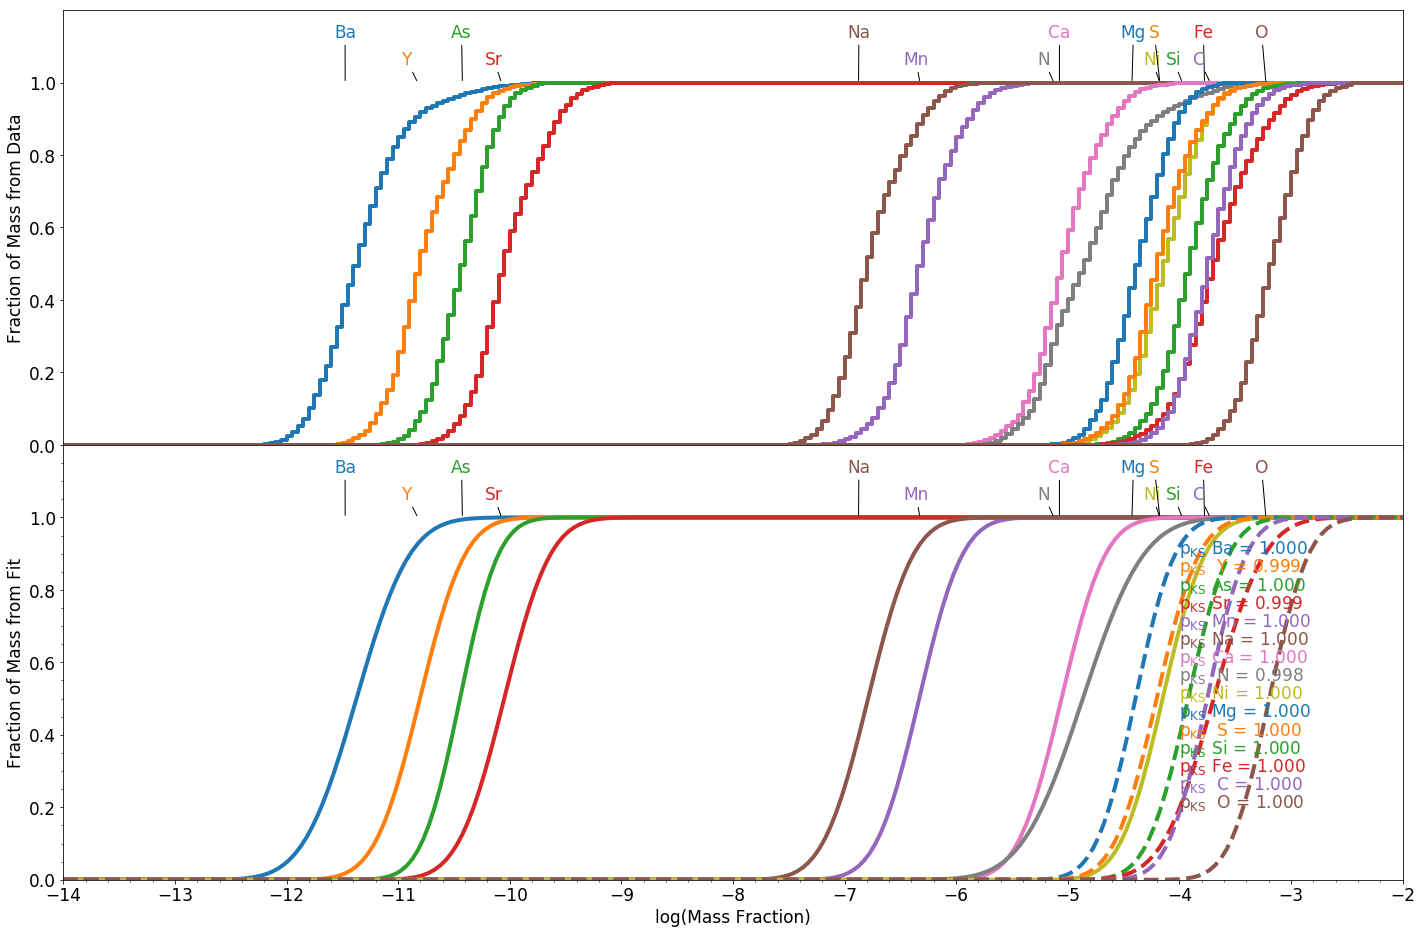

In [18]:
fig, ax = plt.subplots(2)
fig.set_size_inches(24,16)

ds_num  = 300
dsname = 'DD%0004i'%(ds_num)

fbins   = data[dsname]['Disk']['mass_fraction']['bins']
binsize =       (fbins[1:]) - (fbins[:-1])
centers = 0.5 * (fbins[1:] + fbins[:-1])
# phase = 'Molecular'
# field = 'O_Fraction'

keys = data[dsname]['Disk']['mass_fraction'].keys()
keys = [k.split('_F')[0] for k in keys if '_Fraction' in k]
keys = [k for k in keys if len(k) <= 2]
elements = utilities.sort_by_anum([k for k in keys if not k in ['H','He','H1','H2']])
print elements
elements = ['Ba','Y','As','Sr','Mn','Na','Ca','N','Ni','Mg','S','Si','Fe','C','O']
print elements

def _load_data(ldata, dsname, phase, field, centers = None):
    y      = ldata[dsname][phase]['mass_fraction'][field]['hist']
    mean   = ldata[dsname][phase]['mass_fraction'][field]['mean']
    std    = ldata[dsname][phase]['mass_fraction'][field]['std']
    label  = ldata[dsname]['general']['Time'] - 46.0
    
    #if (not ('median' in ldata[dsname][phase]['mass_fraction'][field].keys())):
    median = np.log10(np.interp(0.5, np.cumsum(y)/(1.0*np.sum(y)), centers))
    #else:
    #    print 'loading median from file'
    #    median = ldata[dsname][phase]['mass_fraction'][field]['median']
        
    return y, mean, median, std, label


plot_log = False

xmin = 10000
xmax = -1000000

colors = ['C' + str(i) for i in np.arange(9)]
lss     = ['-','--']
ci = li = 0

xprev = -1000
plot_median = {}


ymax_order = np.zeros(np.size(elements))
phase = 'HIM'    
for i, e in enumerate(elements):
    field = e + '_Fraction'
    y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
    ymax_order[i] = np.argmax(y/binsize)
    
sort = np.argsort(ymax_order)
sort_e = np.array(elements)[sort]

label_pos = np.empty((np.size(elements),))
label_pos[::2] = 1
label_pos[1::2] = -1

label_pos = label_pos[sort]
#print sort_e
    
xychi_y = 0.9

for i, e in enumerate(elements):
    dsname = 'DD%0004i'%(ds_num)
    
    field = e + '_Fraction'
        
    centers = 0.5 * (fbins[1:] + fbins[:-1])
    y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
        
    frac   = 0.8
    alpha = halpha = 1.0
    # alpha  = ((i / (np.size(elements)*1.0))) * frac
    # halpha = ((i / (np.size(elements)*1.0))) * frac * 0.5
    # color  = magma(i/(1.0*np.size(elements))) #'black' # viridis(alpha)    
    
    color = colors[ci]
    ls    = lss[li]

    _compute_fit_and_plot(ax[0], fbins, y, plot_CDF = True,
                                                     alpha = alpha, halpha = halpha, color = color)
    
    xplot, mean_fit, std_fit, output = _compute_fit_and_plot(ax[1], fbins, y, mean = mean, median = median, std = std, plot_CDF = True,
                                                     alpha = alpha, halpha = halpha, color = color, show_hist = False, ls = ls, method = 'KS')
    
    
    p = np.exp( -7.01256*output['D_KS']**2 * (output['npoints'] + 2.78019) + 2.99587*output['D_KS']*(output['npoints']+2.78019)**(0.5) - 0.122119 + 0.97498/output['npoints']**(0.5) + 1.67997/output['npoints'] )
    
    print e, output['D_KS'], output['mean'], output['std'], output['KS_pval']
    
    if plot_log:
        ytext = 4.0
    else:
        ytext = 1.05
    
    xtext = np.log10(centers[np.argmax(y)]) - 0.1 - 0.05
    xa    = np.log10(centers[np.argmax(y)])
    ya    = 1.0
    
    pos = label_pos[i]
    
    #if np.abs(xtext -xprev) < 0.2:
    if pos > 0:
        xtext = xtext + 0.05
        if plot_log:
            ytext = 2.0
            
        else:
            ytext = 1.125
    # pos   = pos * -1
        
    
    xy = (xtext, ytext)
    xya = (xa,ya)
    
    ax[0].annotate(e, xy = xya, xytext=xy, color = color, 
                   arrowprops=dict(arrowstyle="-", connectionstyle="arc3"))
    ax[1].annotate(e, xy = xya, xytext=xy, color = color, 
                   arrowprops=dict(arrowstyle="-",connectionstyle="arc3"))
    xprev = xy[0]
    
    xychi = (-4, xychi_y)
    xychi_y = xychi_y - 0.05
    ax[1].annotate(r'p$_{\rm KS}$ %2s = %0.3f'%(e,output['KS_pval']),
                   xy = xychi, xytext=xychi, color = color)        
    ci = ci + 1
    if ci >= np.size(colors):
        ci = 0
        li = li + 1
        
for i in [0,1]:
    ax[i].set_xlim(xmax - 5, xmax)
    if plot_log:
        ax[i].semilogy()
        ax[i].set_ylim(1.0E-5,8.0)
        ax[i].set_xlim(-14,-1.5)
        ax[i].set_xticks(np.arange(-14,-1))
    else:
        ax[i].set_ylim(0.0,1.2)
        ax[i].set_xlim(-14,-2)
        ax[i].set_xticks(np.arange(-14,-1))
        ax[i].set_yticks(np.arange(0,11,2)/10.0)
        
    ax[i].set_xlabel(r'log(Mass Fraction)')


ax[0].set_ylabel('Fraction of Mass from Data')
ax[1].set_ylabel('Fraction of Mass from Fit')
    
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.minorticks_on()
#ax[(0,0)].set_xlim(
#ax[(0,0)].

#fig.savefig(field + '_phase_evolution.png')
#plt.tight_layout()
outname = 'lognorm_CDF_all_elements_' + phase + '.png'
if plot_log:
    outname = 'log_' + outname
fig.savefig(outname)

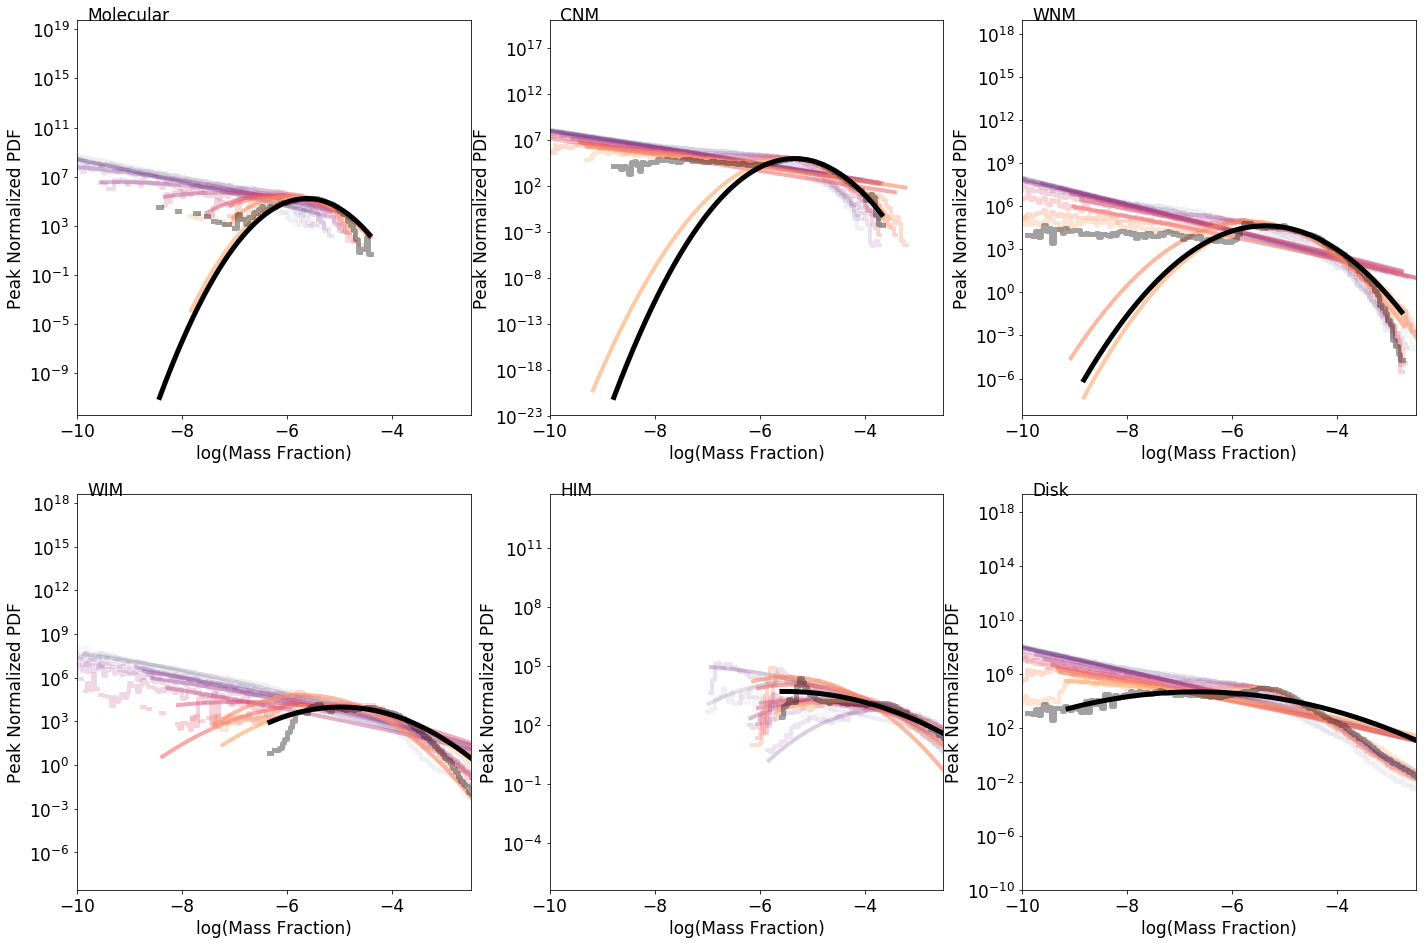

In [16]:
nrow = 2
ncol = 3

fig, all_ax = plt.subplots(nrow,ncol)
fig.set_size_inches(8*ncol,8*nrow)

fbins   = data['DD0100']['Disk']['mass_fraction']['bins']
binsize =       (fbins[1:]) - (fbins[:-1])
centers = 0.5 * (fbins[1:] + fbins[:-1])

phase = 'Molecular'
field = 'O_Fraction'
ylim = [0.0,6]

ds_list = np.arange(60, 120, 5)

min_median = 1.0E80
max_median = -1.0E80

axi = 0
axj = 0
phases = ['Molecular','CNM','WNM','WIM','HIM','Disk']


mean_phase = {}
std_phase  = {}
actual_mean_phase = {}
actual_std_phase  = {}
time = np.zeros(np.size(ds_list))

for k in phases:
    mean_phase[k] = np.zeros(np.size(ds_list))
    std_phase[k]  = np.zeros(np.size(ds_list))
    actual_mean_phase[k] = np.zeros(np.size(ds_list))
    actual_std_phase[k]  = np.zeros(np.size(ds_list))


xmin = 10000
xmax = -1000000


for i,j in enumerate(ds_list):
    dsname = 'DD%0004i'%(j)
    axi = 0
    axj = 0
    for ip, phase in enumerate(phases):
       # print axi, axj, phase
        ax = all_ax[(axi, axj)]
        
        y = data[dsname][phase]['mass_fraction'][field]['hist']
        mean = data[dsname][phase]['mass_fraction'][field]['mean']
        std = data[dsname][phase]['mass_fraction'][field]['std']
        median = np.log10(np.interp(0.5, np.cumsum(y)/(1.0*np.sum(y)), centers))
        label = data[dsname]['general']['Time'] - 46.0
    
       # centers = 0.5 * (fbins[1:] + fbins[:-1])
       # y, mean, median, std, label = _load_data(data, dsname, phase, field, centers = centers)
    
        min_median = np.min([median, min_median])
        max_median = np.max([median, max_median])
    
        frac = 0.8
        alpha = ((i / (np.size(ds_list)*1.0))) * frac
        halpha = ((i / (np.size(ds_list)*1.0))) * frac * 0.5
        color = magma(alpha/frac) #'black' # viridis(alpha)
        lw   = 4.0
        hlw  = 4.0
        if j == np.max(ds_list):
            color = 'black'
            alpha = 1.0
            lw    = 5.0
            hlw   = 5.0
    
        norm_y = y / binsize
        plot_bins = np.log10(fbins)
        norm = np.max(norm_y)
        norm = 1.0
        plot_histogram(ax, plot_bins, norm_y/norm, lw = hlw, color = color, alpha = halpha)

        selection = (y > 0) * (centers > 10**(median - 4)) * (centers < 10**(median+4))
        fit_x     = centers[selection]
        y_to_fit  = norm_y[selection]
    
        # take initial guess parameters from distribution values - compute logged dist values
        u_guess   = np.log( mean / (np.sqrt(1.0 + std*std/(mean*mean))))
        std_guess = np.sqrt(np.log(1.0 + std*std/(mean*mean)))
        xplot = np.logspace(np.log10(np.min(fit_x)), np.log10(np.max(fit_x)),4000)

        try:
            lognorm    = functions.lognormal()
            popt, pcov = lognorm.fit_function(fit_x, y_to_fit, p0 = [u_guess, std_guess])     
            xplot = np.logspace(np.log10(np.min(fit_x)), np.log10(np.max(fit_x)),4000)
            yplot = lognorm._f(xplot, *popt)
            
            norm = np.max(yplot)
            norm = 1.0
            ax.plot(np.log10(xplot), yplot/norm, lw = lw, color = color , ls = '-', alpha = alpha) #, label = 'Fit')     
        except:
            print phase, dsname, 'failure'
            popt = [None, None]
            
        mean_phase[phase][i] = popt[0]
        actual_mean_phase[phase][i] = mean
        std_phase[phase][i]  = popt[1]
        actual_std_phase[phase][i]  = std
        time[i]              = label
        
        axj = axj + 1
        
        if axj >= ncol:
            axi = axi + 1
            axj = 0
        

        xmin = np.min([np.log10(xplot[0]),xmin])
        xmax = np.max([np.log10(xplot[-1]),xmax])
        
        
for i in np.arange(2):
    for j in np.arange(3):
        all_ax[(i,j)].set_xlim(xmax - 5, xmax)
        #all_ax[(i,j)].set_ylim(1.0E-4,1.0)
        all_ax[(i,j)].semilogy()
        ba =  8
        ba = 0
        all_ax[(i,j)].set_xlim(-10 - ba, -2.5 - ba)   

        xy = (np.min(all_ax[(i,j)].get_xlim())+ 0.2,np.max(all_ax[(i,j)].get_ylim())*0.95)
        all_ax[(i,j)].annotate(phases[(3)*(i) + j], xy = xy, xytext=xy)
        all_ax[(i,j)].set_xlabel(r'log(Mass Fraction)')
        all_ax[(i,j)].set_ylabel(r'Peak Normalized PDF')
    #ax.set_xlim( np.log10(min_median) - 2, np.log10(max_median) + 2)

fig.savefig(field + '_phase_evolution.png')

In [17]:
time

array([ 13.99999461,  18.99999241,  23.99999574,  28.99999265,
        33.99999766,  38.99999479,  43.99999265,  48.99999002,
        53.99999051,  58.99999158,  63.99999229,  68.9999933 ])

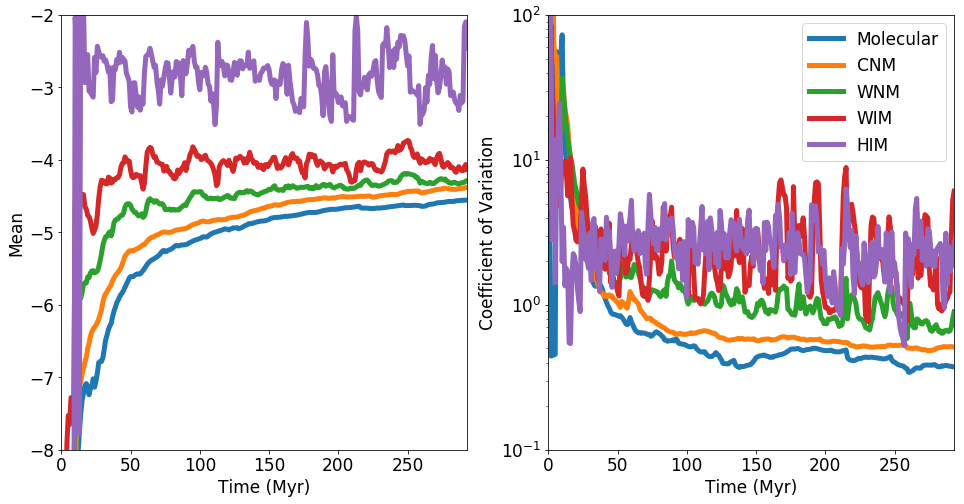

In [80]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

for i, phase in enumerate(phases):
    if phase == 'Disk':
        continue
    mean  = actual_mean_phase[phase]
    std  = actual_std_phase[phase]
    
    # mean = np.exp(M + 0.5*S**2)
    # std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
    
    ax[0].plot(time, np.log10(mean), lw = 5, ls = '-')
    ax[1].plot(time, std / mean,  lw = 5, ls = '-', label = phase)

    ax[0].set_ylabel(r'Mean')
    ax[1].set_ylabel(r'Coefficient of Variation')
    
for a in [ax[0],ax[1]]:
    a.set_xlim(0.0, np.max(time))
    a.set_xlabel('Time (Myr)')
ax[1].semilogy()
ax[0].set_ylim(-8, -2)
ax[1].set_ylim(1.0E-1, 100.0)

    
    
ax[1].legend(loc='best')
fig.savefig('phase_mean_var_from_distribution.png')

/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


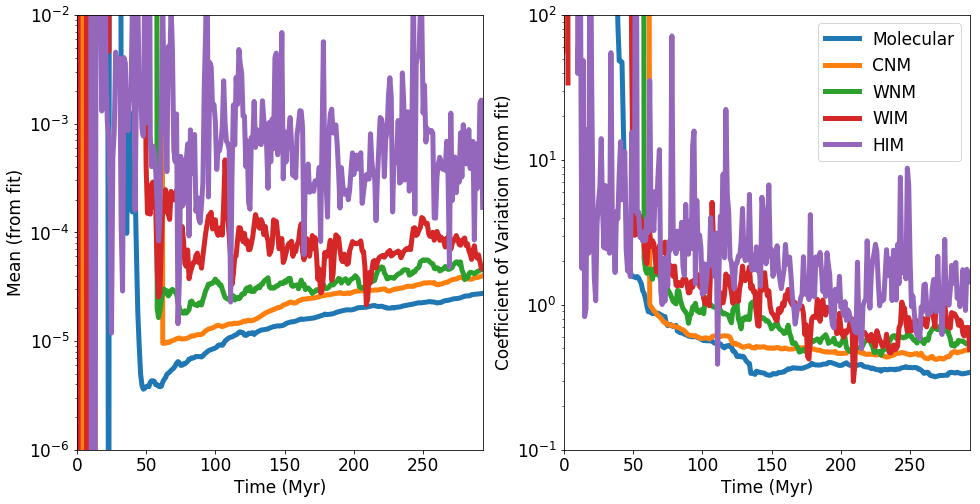

In [39]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

for i, phase in enumerate(phases):
    if phase == 'Disk':
        continue
    M  = mean_phase[phase]
    S  = std_phase[phase]
    
    mean = np.exp(M + 0.5*S**2)
    std  = np.sqrt(np.exp(S**2 + 2.0 * M)*(np.exp(S*S) - 1.0))
    
    #select = 
    
    ax[0].plot(time, mean, lw = 5, ls = '-')
    ax[1].plot(time, std / mean,  lw = 5, ls = '-', label = phase)

    ax[0].set_ylabel(r'Mean (from fit)')
    ax[1].set_ylabel(r'Coefficient of Variation (from fit)')
    
for a in [ax[0],ax[1]]:
    a.set_xlim(0.0, np.max(time))
    a.set_xlabel('Time (Myr)')
    a.semilogy()
ax[0].set_ylim(1.0E-6, 1.0E-2)
ax[1].set_ylim(0.1, 100.0)

    
    
ax[1].legend(loc='best')

fig.savefig('phase_mean_var_from_fit.png')

In [40]:
ptimes = ds_list # in Myr
dt = 100.0

bins = np.arange(-15,-2, 0.2)

all_hist = {}

for i, t in enumerate(ptimes):
    selection = ptypes.select_formed_stars(gal.ds, gal.df, np.max([t - dt, 0.0]), 
                                                             np.min([t + dt, np.max(ptimes)]))
    
    ydata = np.log10(gal.df['particle_O_fraction'][selection])
    hist, bins = np.histogram(ydata, bins = bins)
    hist = hist / (10**(bins[1:]) - 10**(bins[:-1])) / (1.0 * np.size(ydata)) # normalize to PDF
    
    all_hist[t] = hist


/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/emerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


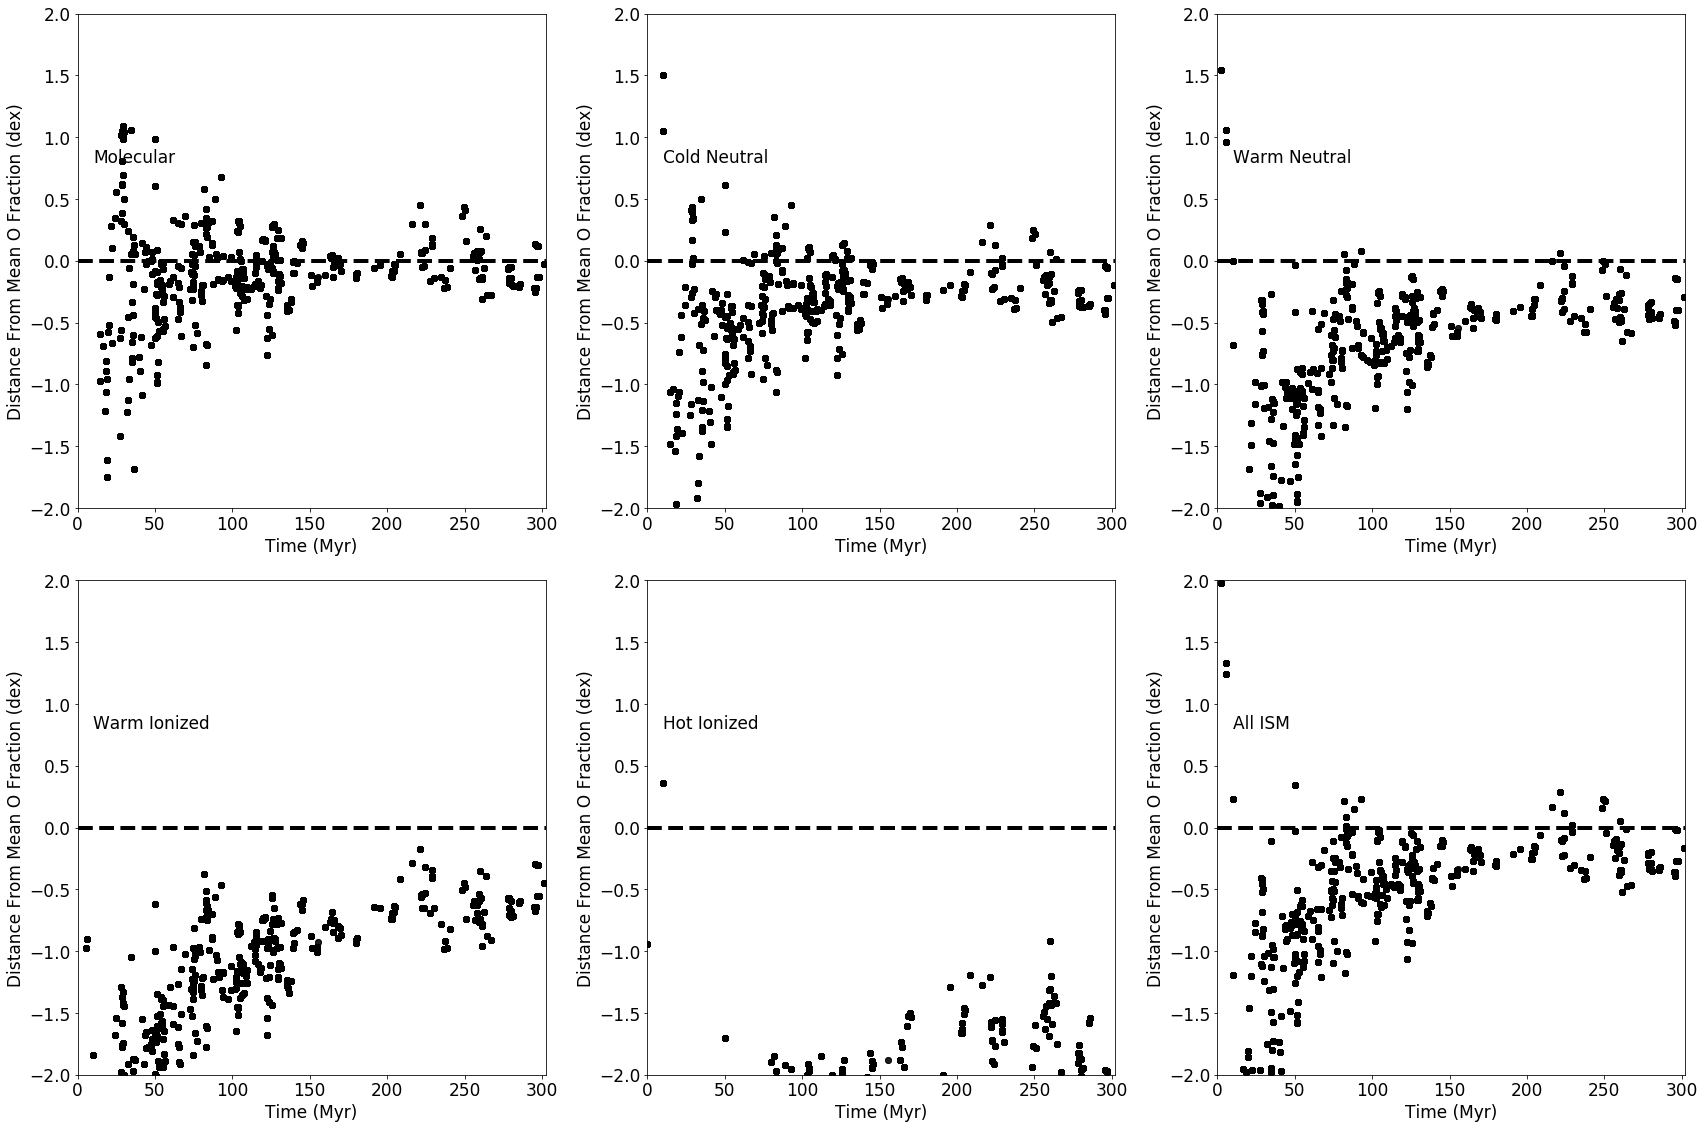

In [77]:
t_o    = gal.df['creation_time'].convert_to_units('Myr')
xdata  = time + 46.0

fig, all_axes = plt.subplots(2,3)
fig.set_size_inches(24,16)

axi = axj = 0
for i,phase in enumerate(['Molecular','CNM','WNM','WIM','HIM','Disk']):
    ax = all_axes[(axi,axj)]
    xdata  = time + 46.0

    mean = actual_mean_phase[phase]
    std  = actual_std_phase[phase]

#mean = np.exp(mol_mean + 0.5*mol_std**2)
#std  = np.sqrt(np.exp(mol_std**2 + 2.0 * mol_mean)*(np.exp(mol_std*mol_std) - 1.0))

    xdata = xdata[std>0]
    mean = mean[std>0]
    std  = std[std>0]

    # number of standard deviations away from mean for each star
    sigma_stars = (np.log10(gal.df['particle_O_fraction']) - np.log10(np.interp(t_o, xdata, mean))) #/ np.interp(t_o, xdata, std)

    x = gal.df[('io','particle_Fe_over_H')]
    ax.scatter(t_o - np.min(t_o), sigma_stars, alpha = 0.5, color = 'black')
    ax.set_xlim(np.min(t_o-np.min(t_o)), np.max(t_o-np.min(t_o)))
    #ax.set_xlim(-8,0)
    ax.set_ylim(-2,2)
    ax.plot(ax.get_xlim(), [0.0,0.0], color = 'black', lw = 4, ls = '--')
    ax.set_ylabel('Distance From Mean O Fraction (dex)')
    ax.set_xlabel('Time (Myr)')
    
    xy = (10.0, ax.get_ylim()[1] - 0.2)
    ax.annotate(phase_labels[i], xy=xy,xytext=xy)
    
    axj = axj + 1
    if axj >= 3:
        axj = 0
        axi = axi + 1
plt.tight_layout()
fig.savefig('stellar_distance_to_mean.png')

In [53]:
np.max(gal.df['particle_O_fraction'])

6.33349351965e-05 dimensionless

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

for i in [150, 200, 250, 300]:
    plot_histogram(ax, bins, all_hist[i] , lw = 3)
 #   print i, all_hist[i]
ax.set_xlabel('log(O Fraction)')
ax.set_ylabel('PDF')
ax.set_xlim(-8,-3)
ax.semilogy()

In [ ]:
    lognorm?


True
False
False
False
False
